### Group Members: Akhil Iyer, Asha Karmakar, Grace Kim, Megan Sundheim

In [1]:
from collections import Counter
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import math
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import numpy as np
import pandas as pd
import random
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
import seaborn as sns
from sklearn import tree
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.manifold import MDS
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, silhouette_score, silhouette_samples
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Introduction

The problem of classifying songs based on their musical features is important in the world of audio-recognition systems like Shazam, that may measure musical features through a device's microphone and return its prediction of the song genre. Furthermore, the predictions of song genres may be useful for recommender systems and AI-generated playlists for specific users' preferences, as well as automatic classification of genres for artists uploading music to music apps.

In this project, we will be classifying the genres of a set of 42,305 Spotify songs from Andrii Samoshyn on Kaggle (https://www.kaggle.com/datasets/mrmorj/dataset-of-songs-in-spotify). Using 13 out of 22 musical features available in the dataset, such as energy, instrumentalness, tempo, and key, we will attempt to classify songs into one of 15 music genres.

# Data Preprocessing, Data Exploration, and Feature Engineering

Before deciding on the classifiers to use for classifying song genre, we first explored the available features to better understand what features we deemed important, what challenges we might face in training classifiers (i.e. high dimensionality, class imbalance, etc.), and whether we would need to drop anomalous data or redundant features.

We decided to drop type, id, uri, track_href, analysis_url, unnamed, title, and song_name since these features were identifiers specific to the Spotify app, were redundant, and/or were song names, which would lie outside the scope of this class as a Natural Language Processing problem.

Except for decision tree and random forest classification below, we used a dataset with one-hot-encoded time signatures since this was our only categorical feature and we planned to use a majority of mathematics-based classifiers.

In [2]:
# Read in csv file
df = pd.read_csv("./data/genres.csv", low_memory=False)

In [3]:
# Clean data.
# Remove the following columns: type, id, uri, track_href, analysis_url, unnamed, title, song_name.
df = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'genre']]
df_dt = df.copy() # Saved for decision tree.

In [12]:
# One hot encode time signature (categorical feature value).
df = pd.get_dummies(df, columns=['time_signature'], drop_first=False)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genre,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.831,0.814,2,-7.364,1,0.4200,0.059800,0.013400,0.0556,0.3890,156.985,124539,Dark Trap,False,False,True,False
1,0.719,0.493,8,-7.230,1,0.0794,0.401000,0.000000,0.1180,0.1240,115.080,224427,Dark Trap,False,False,True,False
2,0.850,0.893,5,-4.783,1,0.0623,0.013800,0.000004,0.3720,0.0391,218.050,98821,Dark Trap,False,False,True,False
3,0.476,0.781,0,-4.710,1,0.1030,0.023700,0.000000,0.1140,0.1750,186.948,123661,Dark Trap,False,True,False,False
4,0.798,0.624,2,-7.668,1,0.2930,0.217000,0.000000,0.1660,0.5910,147.988,123298,Dark Trap,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42300,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208,hardstyle,False,False,True,False
42301,0.517,0.768,0,-7.922,0,0.0479,0.022500,0.000018,0.2050,0.3830,149.928,210112,hardstyle,False,False,True,False
42302,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823,hardstyle,False,False,True,False
42303,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200,hardstyle,False,False,True,False


In [10]:
# Separate data into features and class labels.
features = df.drop('genre', axis=1)
labels = df['genre']

In [11]:
print(features.head())
print()

# Save list of unique genre labels for later use.
label_groups = df.groupby('genre')
unique_genres = sorted(list(set(list(labels))))
print(label_groups.size())

   danceability  energy  key  loudness  mode  speechiness  acousticness   
0         0.831   0.814    2    -7.364     1       0.4200        0.0598  \
1         0.719   0.493    8    -7.230     1       0.0794        0.4010   
2         0.850   0.893    5    -4.783     1       0.0623        0.0138   
3         0.476   0.781    0    -4.710     1       0.1030        0.0237   
4         0.798   0.624    2    -7.668     1       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  
0          0.013400    0.0556   0.3890  156.985       124539               4  
1          0.000000    0.1180   0.1240  115.080       224427               4  
2          0.000004    0.3720   0.0391  218.050        98821               4  
3          0.000000    0.1140   0.1750  186.948       123661               3  
4          0.000000    0.1660   0.5910  147.988       123298               4  

genre
Dark Trap          4578
Emo                1680
Hiphop             3

## Checking for Missing Values

Before preceding with our use of our separated feature and label dataframes, we double-checked that there were no missing values in our dataset, then proceeded with our data exploration.

In [133]:
# There are no missing values:
null_data = df[df.isnull().any(axis=1)]
len(null_data)

0

## Feature Engineering and Correlation

To determine if we could remove or combine any redundant, highly correlated features to mitigate for the curse of dimensionality in our dataset, we plotted the correlation matrix between all features. We found that most features shared a low positive or negative correlation with each other, so we decided to not add or remove any features at this point in our project.

[Text(0.5, 0, 'danceability'),
 Text(1.5, 0, 'energy'),
 Text(2.5, 0, 'key'),
 Text(3.5, 0, 'loudness'),
 Text(4.5, 0, 'mode'),
 Text(5.5, 0, 'speechiness'),
 Text(6.5, 0, 'acousticness'),
 Text(7.5, 0, 'instrumentalness'),
 Text(8.5, 0, 'liveness'),
 Text(9.5, 0, 'valence'),
 Text(10.5, 0, 'tempo'),
 Text(11.5, 0, 'duration_ms'),
 Text(12.5, 0, 'time_signature_1'),
 Text(13.5, 0, 'time_signature_3'),
 Text(14.5, 0, 'time_signature_4'),
 Text(15.5, 0, 'time_signature_5')]

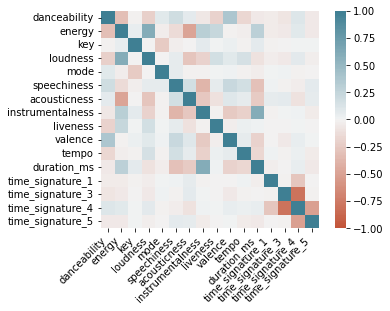

In [134]:
# Plot correlation between features.
ax = sns.heatmap(
    features.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

## Anomaly Detection

Next, we performed anomaly detection using probabilistic, proximity-based, and density-based anomaly detection methods since we could not visualize the data with all 17 of our current features.

Since we had so many data points in our dataset, we decided to discard any data point classified as an anomaly in any of our 3 methods. This resulted in about 34,000 data points with class imbalance (Underground Rap being more than 10x as represented as Pop in our new dataset). We will later investigate the effect of removing anomalous data points on the performance of our classifiers.

In [135]:
# Perform anomaly detection.
y_pred_list = []

# Probabilistic anomaly detection.
envelope_pred = EllipticEnvelope().fit_predict(features)
y_pred_list.append(envelope_pred)

# Proximity-based anomaly detection.
forest_pred = IsolationForest().fit_predict(features)
y_pred_list.append(forest_pred)

# Density-based anomaly detection.
lof_pred = LocalOutlierFactor().fit_predict(features)
y_pred_list.append(lof_pred)

y_pred_list

[array([ 1, -1,  1, ...,  1,  1,  1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1])]

Counter({1: 38074, -1: 4231})
Counter({1: 38023, -1: 4282})
Counter({1: 40473, -1: 1832})

genre
Dark Trap          3191
Emo                1245
Hiphop             2037
Pop                 362
Rap                1291
RnB                1410
Trap Metal         1419
Underground Rap    4310
dnb                2758
hardstyle          2664
psytrance          2703
techhouse          2789
techno             2479
trance             2767
trap               2727
dtype: int64

Size of new dataset: 34152


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

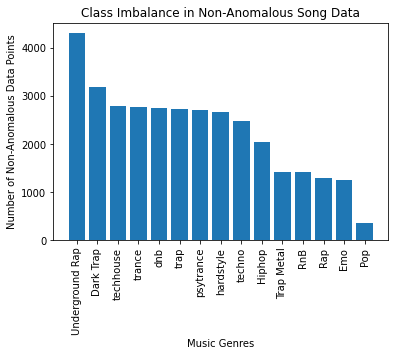

In [136]:
# Drop anomalous points.
features_no_anomalies = features.copy()
labels_no_anomalies = labels.copy()
anomaly_indices = set()
for arr in y_pred_list:
    c = Counter(arr)
    print(c)
    i = len(arr) - 1
    while i >= 0:
        if arr[i] == -1:
            anomaly_indices.add(i)
        i -= 1
        
# Drop anomalies indicated by any of the 3 anomaly detection algorithms.
anomaly_indices = list(anomaly_indices)
anomaly_indices.sort()
features_no_anomalies = features_no_anomalies.drop(anomaly_indices, axis=0)
labels_no_anomalies = labels_no_anomalies.drop(anomaly_indices, axis=0)

features_no_anomalies = features_no_anomalies.reset_index().drop('index', axis=1)
labels_no_anomalies = labels_no_anomalies.reset_index().drop('index', axis=1)
label_groups = labels_no_anomalies.groupby('genre')
print()
print(label_groups.size())
print("\nSize of new dataset: %i" % len(features_no_anomalies))

# Display class imbalance with bar graph.
sorted_labels = label_groups.size().sort_values(ascending=False)
sorted_labels = sorted_labels.reset_index()
plt.bar(sorted_labels['genre'], sorted_labels[0])
plt.title('Class Imbalance in Non-Anomalous Song Data')
plt.xlabel('Music Genres')
plt.ylabel('Number of Non-Anomalous Data Points')
plt.xticks(rotation=90)

## Exploring Similarity of Genres

Throughout the course of our modeling process, we noticed that there was a wide disparity in performance between genres with our full dataset, non-anomalous and imbalanced dataset, and our non-anomalous and balanced dataset. We postulated that because music genres are subjectively classified by humans, certain genres may have more similar music features among their songs than others.

The following plots show that when we project the non-anomalous data onto 2 dimensions (preserving similarity), all the genres appear to be interspersed with each other in a single blob, with individual genres ranging in density. These observations will later be explored when looking at the relative cohesion of these genres in relation to classifier performance.

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


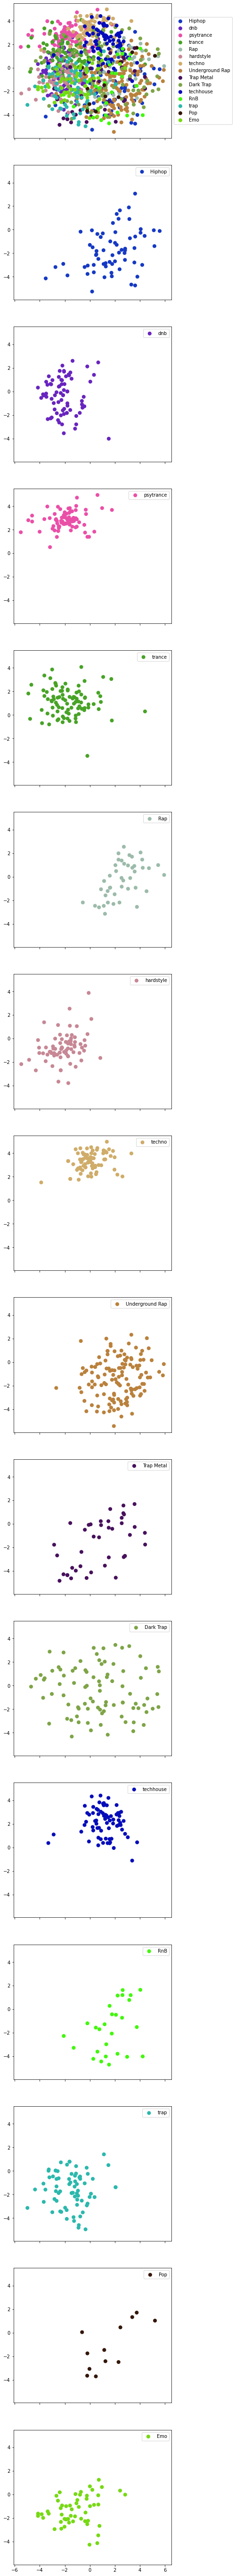

In [137]:
# Modified code from scatter() function from HW 5.
# Print the labeled data clusters after anomalies taken out.

# Scale non-anomalous data.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_no_anomalies)
pca = PCA(n_components=0.95, svd_solver='full')
features_scaled = pca.fit_transform(features_scaled)

# Sample subset of scaled data points.
numPoints = 1000
numEntries = features_scaled.shape[0]
samp_records = []
samp_labels = []
for i in range(numPoints):
    index = random.randint(0, numEntries - 1)
    samp_records.append(features_scaled[index, :])
    samp_labels.append(labels_no_anomalies.iloc[index, 0])

# Generate different color for each genre.
label_colors = []
color_dict = dict()
for label in samp_labels:
    if not label in color_dict.keys():
        # noanominally found in https://stackoverflow.com/questions/28999287/generate-random-colors-rgb.
        color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        color_dict[label] = color
    label_colors.append(color_dict[label])

# Project sampled data down onto 2 dimensions to visualize similarity.
mds = MDS(n_components=2)
mds_data = mds.fit_transform(samp_records)

# Assign label for each data point.
classes = dict()
for i in range(len(mds_data)):
    record = mds_data[i]
    label = samp_labels[i]
    if not label in classes.keys():
        classes[label] = [record]
    else:
        classes[label].append(record)

# Plot cluster of sampled data for each individual genre.
fig, axes = plt.subplots(len(classes.keys()) + 1, 1, figsize=(6, 100), sharey=True, sharex=True)
index = 1
for genre in classes.keys():
    ax = axes[index]
    index += 1
    data = pd.DataFrame(classes[genre])
    color = [color_dict[genre] for i in range(len(data))]
    axes[0].scatter(data.iloc[:, 0], data.iloc[:, 1], c=color, s=50, label=genre)
    ax.scatter(data.iloc[:, 0], data.iloc[:, 1], c=color, s=50, label=genre)

# Originally found in https://towardsdatascience.com/legend-outside-the-plot-matplotlib-5d9c1caa9d31#:~:text=Placing%20the%20legend%20outside%20of%20the%20plot&text=First%2C%20we%20need%20to%20shrink,control%20for%20manual%20legend%20placement.&text=Box%20that%20is%20used%20to,Defaults%20to%20axes.
axes[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
index = 1

# Plot all genres onto one scatterplot.
while index <= len(classes.keys()):
    ax = axes[index]
    ax.legend(loc='best')
    index += 1

## Mitigating Class Imbalance

Noted above, there is significant class imbalance among the number of songs in each genre in the dataset. To mitigate for this class imbalance, we took advantage of the large size of the non-anomalous dataset and downsampled into a balanced subset of songs. The new non-anomalous, balanced dataset has an equal number of random samples for each genre.

In [138]:
# Downsample data to mitigate for class imbalance.
min_size = math.inf
for genre in label_groups.groups.keys():
    genre_group = label_groups.get_group(genre)
    if len(genre_group) < min_size:
        min_size = len(genre_group)
num_samples = min_size

# Sample same number of points from each genre to balance classes.
samp_features = []
samp_genres = []
samp_records = []
df_no_anomalies = pd.DataFrame(features_no_anomalies.copy())
df_no_anomalies['genre'] = labels_no_anomalies
genres = df_no_anomalies.groupby('genre')
for genre in genres.groups.keys():
    genre_group = genres.get_group(genre)
    genre_group_copy = genre_group.copy()
    genre_group_copy = genre_group_copy.reset_index()
    for i in range(num_samples):
        index = random.randint(0, len(genre_group_copy) - 1)
        samp_records.append(genre_group_copy.iloc[index, :])

samp_features = pd.DataFrame(samp_records).set_index('index')
samp_genres = pd.DataFrame(samp_features['genre'])
samp_features = samp_features.drop('genre', axis=1)
print(samp_features)
print(samp_genres)

for genre in classes.keys():
    # Sum WSS over each genre.
    cohesion = 0
    data = df_no_anomalies[df_no_anomalies['genre'] == genre].drop('genre', axis=1)
    centroid = np.mean(data, axis=0)

print("Balanced downsampled labels:")
print(samp_genres.groupby('genre').size())

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
index                                                                         
813           0.900   0.783   10    -4.498     0       0.2280       0.00373   
1168          0.882   0.545    0    -6.977     1       0.2900       0.27300   
1811          0.703   0.661    7    -7.359     0       0.0408       0.01120   
2791          0.773   0.815    9    -7.762     1       0.0614       0.00106   
2311          0.620   0.932    8    -6.303     1       0.0438       0.01320   
...             ...     ...  ...       ...   ...          ...           ...   
27080         0.575   0.961    1    -1.888     0       0.1760       0.00897   
26879         0.591   0.901   10    -1.039     0       0.0761       0.00371   
27152         0.823   0.723    0    -7.540     1       0.4990       0.05090   
26004         0.407   0.908    1    -4.819     1       0.1120       0.00263   
26762         0.661   0.808    0    -5.067     1    

# Modeling

## Naive Bayes

As part of our group's brainstorming process for which classifier types would be most appropriate to train our data on, we chose to try Naive Bayes since it is not susceptible to the curse of dimensionality (and we have a quite a few features we are using). Since Naive Bayes assumes that all features are conditionally independent of each other given the label and our features were weakly correlated with each other, we thought this was an additional reason this classifier could be appropriate.

Gaussian Naive Bayes was the only subtype of this classifier that we were able to use since it allowed for use of continuous feature values. Multinomial and Categorical required discrete feature values, Complement needed nonnegative values, and Bernoilli relied on binary feature values, so we couldn't use any of these while using all of our features (original and reduced dimensionality).

### Training with Full Dataset and Non-Anomalous Data

We first trained 2 different Gaussian Naive Bayes classifiers with 10-fold cross validation for all of our data and 
for our data without the anomalies detected during data exploration and cleaning. This was to determine how much anomalies skewed the classifier's feature probability distributions. 

In [139]:
# Create a Gaussian Naive Bayes classifier.
gnb = GaussianNB()

# Run 10-fold cross validation on classifier.
accuracies = cross_val_score(gnb, features, list(labels), cv=10)

# Print the accuracy of the cross-validated model.
avg_accuracy = accuracies.mean()
print("Accuracy:", (avg_accuracy * 100))


# Create a Gaussian Naive Bayes classifier for data without anomalies.
gnb_no_anomalies = GaussianNB()
labels_no_anomalies = labels_no_anomalies.iloc[:, 0]

# Run 10-fold cross validation on classifier for data without anomalies.
accuracies_no_anomalies = cross_val_score(gnb_no_anomalies, features_no_anomalies, labels_no_anomalies, cv=10)

# Print the accuracy of the cross-validated model for data without anomalies.
avg_accuracy_no_anomalies = accuracies_no_anomalies.mean()
print("Accuracy without anomalies:", (avg_accuracy_no_anomalies * 100))

Accuracy: 49.334593870637356
Accuracy without anomalies: 52.280871002362495


Given our 15 genres to choose from in classification of a song in the dataset, a random classifier would have about a 6.67% chance of choosing a certain genre. Therefore, with our whole data classifier yielding ~49.3% accuracy and the non-anomalous classifier yielding ~52.3% accuracy, both classifiers performed significantly better than random. 

Also worth noting is the improvement in the accuracy of the classifier by 3% after removing anomalies, indicating that the of the ~8000 points we removed, there was some skewing of classes by anomalous feature values.

Due to the severe class imbalance between genres in this dataset, accuracy may not be an accurate depiction of the spread of classification performance across classes. Therefore, we wanted to take a look at the classification matrix and report of other evaluation metrics to investigate the performance of our classifiers.

In [8]:
# Plot the confusion matrix in a more visually appealing heat map.
def plot_confusion_matrix(confusion_mat):
    ax = plt.subplot()
    sns.heatmap(confusion_mat, annot=True, fmt='g', ax=ax)
    sns.set(font_scale=0.75)
    
    # Labels, title and ticks.
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(unique_genres, rotation=90)
    ax.yaxis.set_ticklabels(unique_genres, rotation=0)


Classification Report with Anomalies:
                  precision    recall  f1-score   support

      Dark Trap       0.32      0.03      0.06      4578
            Emo       0.00      0.00      0.00      1680
         Hiphop       0.36      0.23      0.28      3028
            Pop       0.00      0.00      0.00       461
            Rap       0.50      0.29      0.37      1848
            RnB       0.00      0.00      0.00      2099
     Trap Metal       0.49      0.01      0.03      1956
Underground Rap       0.34      0.65      0.44      5875
            dnb       0.72      0.99      0.83      2966
      hardstyle       0.48      0.90      0.63      2936
      psytrance       0.76      0.92      0.83      2961
      techhouse       0.46      0.76      0.57      2975
         techno       0.68      0.80      0.73      2956
         trance       0.40      0.44      0.42      2999
           trap       0.55      0.48      0.51      2987

       accuracy                           0.49

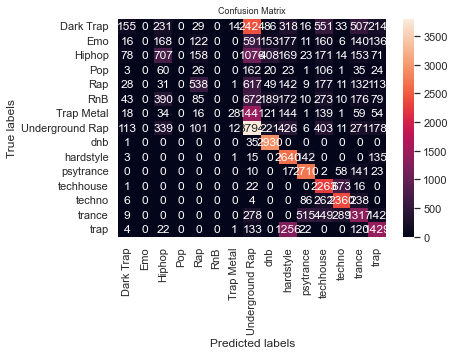

In [266]:
# Original code from Megan Sundheim's HW 4.

# Print the confusion matrix for the whole data classifier.
pred_labels = cross_val_predict(gnb, features, labels, cv=10)
con_mat = confusion_matrix(labels, pred_labels)
plot_confusion_matrix(con_mat)

# Display the classification report for the whole data Naive Bayes classifier.
report = classification_report(labels, pred_labels, zero_division=0)
print("\nClassification Report with Anomalies:\n", report)


Classification Report without Anomalies:
                  precision    recall  f1-score   support

      Dark Trap       0.20      0.01      0.02      3191
            Emo       0.00      0.00      0.00      1245
         Hiphop       0.37      0.25      0.30      2037
            Pop       0.00      0.00      0.00       362
            Rap       0.46      0.19      0.27      1291
            RnB       0.00      0.00      0.00      1410
     Trap Metal       0.56      0.02      0.04      1419
Underground Rap       0.36      0.61      0.45      4310
            dnb       0.75      0.99      0.85      2758
      hardstyle       0.50      0.89      0.64      2664
      psytrance       0.77      0.92      0.84      2703
      techhouse       0.49      0.77      0.60      2789
         techno       0.67      0.78      0.72      2479
         trance       0.42      0.48      0.45      2767
           trap       0.57      0.50      0.53      2727

       accuracy                           0

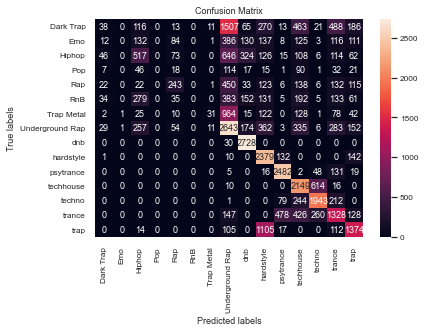

In [267]:
# Original code from Megan Sundheim's HW 4.

# Print the confusion matrix for the classifier without anomalies.
pred_labels_no_anomalies = cross_val_predict(gnb_no_anomalies, features_no_anomalies, labels_no_anomalies, cv=10)
con_mat_no_anomalies = confusion_matrix(labels_no_anomalies, pred_labels_no_anomalies)
plot_confusion_matrix(con_mat_no_anomalies)

# Display the classification report for the Naive Bayes classifier without anomalies.
report_no_anomalies = classification_report(labels_no_anomalies, pred_labels_no_anomalies, zero_division=0)
report_no_anomalies_dict = classification_report(labels_no_anomalies, pred_labels_no_anomalies, zero_division=0, output_dict=True)
print("\nClassification Report without Anomalies:\n", report_no_anomalies)

Between the 2 classification reports, both classifiers seem to especially struggle with Emo, Pop, and RnB, having classified 0 songs as these genres, despite more than a 1000 songs in either dataset being Emo and RnB and all of these genres being relatively distinct and recognizable to the human ear. Similarly surprising was the F1 score being unusually low (0.06 with anomalies and 0.02 without) for Dark Trap despite having the 2nd largest amount of songs in this genre in the data. Psytrance and dnb had F1 scores from 0.83-0.85 in either classifier despite a moderate amount of points in each genre.

### Correlation of Relative Cohesion of Each Genre to F1 Scores

From these observations, we decided to investigate the relationship between cohesion (with relation to number of points in each genre) of the non-anomalous classes and the F1 scores with Gaussian Naive Bayes. Since Naive Bayes assumes that each feature is independent of each other and relies on probability distributions for each feature, perhaps the so-so performance could be attributed to similar feature values across genres.

Also, due to the variety in F1 scores across imbalanced genres, we decided to try Naive Bayes with a downsampled dataset with non-anomalous data.

In [143]:
rel_cohesion = dict()
df_no_anomalies = pd.DataFrame(features_no_anomalies.copy())
df_no_anomalies['genre'] = labels_no_anomalies

# Calculate the cohesion (similarity) between points in each genre.
for genre in classes.keys():
    # Sum WSS over each genre.
    cohesion = 0
    data = df_no_anomalies[df_no_anomalies['genre'] == genre].drop('genre', axis=1)
    centroid = np.mean(data, axis=0)
    for i in range(0, len(data)):
        # Sum WSS over each data point in current cluster.
        record = data.iloc[i, :]
        cohesion += (math.sqrt(((record[0] - centroid[0]) ** 2) + (record[1] - centroid[1]) ** 2)) ** 2
    print("The cohesion of records in %s is %f." % (genre, cohesion))
    print("The cohesion of records in %s, relative to size, is %f.\n" % (genre, (cohesion / len(data))))
    rel_cohesion[genre] = cohesion / len(data)
    
# Sum WSS over all genres.
total_cohesion = 0
total_c = np.mean(features_no_anomalies, axis=0)
for i in range(len(features_no_anomalies)):
    record = features_no_anomalies.iloc[i, :]
    total_cohesion += (math.sqrt(((record[0] - total_c[0]) ** 2) + (record[1] - total_c[1]) ** 2)) ** 2

rel_total = total_cohesion / len(features_no_anomalies)
print("The cohesion of all records is %f." % (total_cohesion))
print("The relative cohesion of all records is %f." % (rel_total))

The cohesion of records in Hiphop is 75.016596.
The cohesion of records in Hiphop, relative to size, is 0.036827.

The cohesion of records in dnb is 55.675599.
The cohesion of records in dnb, relative to size, is 0.020187.

The cohesion of records in psytrance is 42.973413.
The cohesion of records in psytrance, relative to size, is 0.015898.

The cohesion of records in trance is 56.078879.
The cohesion of records in trance, relative to size, is 0.020267.

The cohesion of records in Rap is 37.491620.
The cohesion of records in Rap, relative to size, is 0.029041.

The cohesion of records in hardstyle is 43.822457.
The cohesion of records in hardstyle, relative to size, is 0.016450.

The cohesion of records in techno is 59.402191.
The cohesion of records in techno, relative to size, is 0.023962.

The cohesion of records in Underground Rap is 153.937250.
The cohesion of records in Underground Rap, relative to size, is 0.035716.

The cohesion of records in Trap Metal is 68.282688.
The cohes

In [144]:
# Compute the correlation between Naive Bayes F1 score and relative cohesion of class for non-anomalous data.
genre_f1 = dict()
genres_dict = df.groupby('genre').groups.keys()
corr_df = []
for genre in genres_dict:
    metrics = report_no_anomalies_dict[genre]
    f1 = metrics['f1-score']
    corr_df.append([f1, rel_cohesion[genre]])

corr_df = pd.DataFrame(corr_df, index=genres_dict, columns=['f1-score', 'Relative Cohesion'])
print(corr_df.corr())

                   f1-score  Relative Cohesion
f1-score           1.000000          -0.777925
Relative Cohesion -0.777925           1.000000


The F1 score from Naive Bayes classification and relative cohesion (without anomalies) of each genre appears to be moderately to highly negatively correlated. Cohesion measures the proximity of each point in a cluster to its centroid, so lower cohesion of songs within their actual genres means that songs are more similar to each other. F1 score combines the precision and recall metrics of classification so that a score of 0 is the worst performance and 1 is the best. Therefore, it makes sense for our performance metric F1 score to be negatively correlated to cohesion, as our classifier should have an easier time discerning between genres (higher F1 score) when songs in a genre tend to be more similar to each other (lower cohesion).

Therefore, the performance of our Naive Bayes classifier seems to be moderately to highly influenced by the similarity of songs within a genre.

### Training with Downsampled, Balanced Data

We will lastly train a Gaussian Naive Bayes classifier to determine the effect of class imbalance on the classifier's performance.

Accuracy with Sampled/Balanced Non-Anomalous Data: 45.322283609576424

Classification Report with Sampled/Balanced Non-Anomalous Data:
                  precision    recall  f1-score   support

      Dark Trap       0.25      0.05      0.09       362
            Emo       0.35      0.19      0.25       362
         Hiphop       0.40      0.25      0.30       362
            Pop       0.22      0.22      0.22       362
            Rap       0.33      0.25      0.29       362
            RnB       0.25      0.01      0.03       362
     Trap Metal       0.32      0.54      0.40       362
Underground Rap       0.30      0.07      0.11       362
            dnb       0.71      0.98      0.82       362
      hardstyle       0.45      0.92      0.60       362
      psytrance       0.74      0.90      0.81       362
      techhouse       0.41      0.77      0.53       362
         techno       0.69      0.78      0.73       362
         trance       0.34      0.43      0.38       362
        

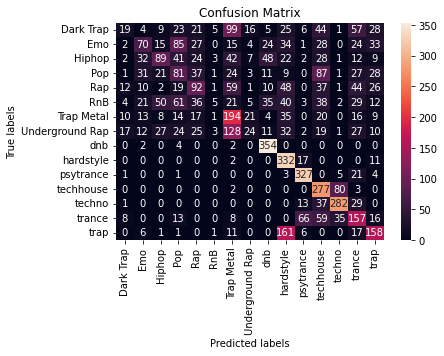

In [145]:
# Run Naive Bayes on sampled data.
gnb_sampled = GaussianNB()

# Run 10-fold cross validation on classifier.
accuracies = cross_val_score(gnb_sampled, samp_features, samp_genres.iloc[:, 0], cv=10)

# Print the accuracy of the cross-validated model.
avg_accuracy = accuracies.mean()
print("Accuracy with Sampled/Balanced Non-Anomalous Data:", (avg_accuracy * 100))


# Original code from Megan Sundheim's HW 4.

# Print the confusion matrix for the classifier with balanced classes.
pred_labels_sampled = cross_val_predict(gnb_sampled, samp_features, samp_genres.iloc[:, 0], cv=10)
con_mat_sampled = confusion_matrix(samp_genres, pred_labels_sampled)
plot_confusion_matrix(con_mat_sampled)

# Display the classification report for the Naive Bayes classifier with balanced classes.
report_sampled = classification_report(samp_genres, pred_labels_sampled, zero_division=0)
print("\nClassification Report with Sampled/Balanced Non-Anomalous Data:\n", report_sampled)

Using the completely balanced downsampled non-anomalous data, the accuracy of our classifer decreased by 0.03 and 0.06 from our whole data and non-anomalous classifiers, respectively. Although the accuracy decreased, this may actually indicate a more honest and fair representation of the classifier's performance on the dataset.

Notably, all genres receive some number of correct predictions (as opposed to Emo, Pop, and Rnb receiving no predictions in the previous two classifiers). Psytrance and dnb still remain as the best performing classes (F1 scores of ~0.80), however Underground Rap saw a huge hit in its performance (a drop of ~0.30). This genre had the most songs in it originally, perhaps indicating a skew in genre performance based on number of points available in the dataset. 

### Naive Bayes Conclusion

Overall, the best performing Naive Bayes classifier was most likely the non-anomalous, imbalanced classifier (with the highest weighted precision, recall, and F1 score overall). However, after balancing the data via downsampling, the imbalanced classifier may have been skewed to improve accuracy in majority classes and ignore minority classes in its training.

## Decision Trees

We decided to try decision tree classifers for our classification task because we have lots of features and the decision tree model doesn't suffer from the curse of dimensionality. Also, decision tree models has the ability to make use of a combination of numerical and categorical features without additional feature engineering, so we used a non-one-hot-encoded version of our dataset saved at the top.

### Datasets for Decision Trees (No One-Hot Encoding)

In [13]:
"""
Because decision trees can handle a mix of numerical and categorical variables, 
we can use the original data without one-hot encoding.
"""
features_dt = df_dt.drop('genre', axis=1)
labels_dt = df_dt['genre']

y_pred_list_dt = []

# Apply EllipticEnvelope AD.
envelope_pred_dt = EllipticEnvelope().fit_predict(features_dt)
y_pred_list_dt.append(envelope_pred_dt)

# Apply IsolationForest AD.
forest_pred_dt = IsolationForest().fit_predict(features_dt)
y_pred_list_dt.append(forest_pred_dt)

# Apply LocalOutlierFactor AD.
lof_pred_dt = LocalOutlierFactor().fit_predict(features_dt)
y_pred_list_dt.append(lof_pred_dt)

features_no_anomalies_dt = features_dt.copy()
labels_no_anomalies_dt = labels_dt.copy()
anomaly_indices_dt = set()
for arr in y_pred_list_dt:
    c = Counter(arr)
    print(c)
    i = len(arr) - 1
    while i >= 0:
        if arr[i] == -1:
            anomaly_indices_dt.add(i)
        i -= 1
        
# Drop anomalies indicated by any of the 3 anomaly detection algorithms.
anomaly_indices_dt = list(anomaly_indices_dt)
anomaly_indices_dt.sort()
features_no_anomalies_dt = features_no_anomalies_dt.drop(anomaly_indices_dt, axis=0)
labels_no_anomalies_dt = labels_no_anomalies_dt.drop(anomaly_indices_dt, axis=0)

features_no_anomalies_dt = features_no_anomalies_dt.reset_index().drop('index', axis=1)
labels_no_anomalies_dt = labels_no_anomalies_dt.reset_index().drop('index', axis=1)
label_groups_dt = labels_no_anomalies_dt.groupby('genre')

min_size_dt = math.inf
for genre in label_groups_dt.groups.keys():
    genre_group_dt = label_groups_dt.get_group(genre)
    if len(genre_group_dt) < min_size_dt:
        min_size_dt = len(genre_group_dt)
num_samples_dt = min_size_dt

# Sample same number of points from each genre to balance classes.
samp_features_dt = []
samp_genres_dt = []
samp_records_dt = []
df_no_anomalies_dt = pd.DataFrame(features_no_anomalies_dt.copy())
df_no_anomalies_dt['genre'] = labels_no_anomalies_dt
genres_dt = df_no_anomalies_dt.groupby('genre')
for genre in genres_dt.groups.keys():
    genre_group_dt = genres_dt.get_group(genre)
    genre_group_copy_dt = genre_group_dt.copy()
    genre_group_copy_dt = genre_group_copy_dt.reset_index()
    for i in range(num_samples_dt):
        index = random.randint(0, len(genre_group_copy_dt) - 1)
        samp_records_dt.append(genre_group_copy_dt.iloc[index, :])

samp_features_dt = pd.DataFrame(samp_records_dt).set_index('index')
samp_genres_dt = samp_features_dt['genre']
samp_features_dt = samp_features_dt.drop('genre', axis=1)

Counter({1: 38074, -1: 4231})
Counter({1: 36431, -1: 5874})
Counter({1: 40473, -1: 1832})


In [14]:
# Train and run decision tree classifier on given dataset.
def decision_tree_clf(features, labels):
    dt_model = tree.DecisionTreeClassifier()
    parameters = {'criterion':["gini", "entropy"], 'max_depth':[5, 10, 15, 20], 'min_samples_leaf':[5, 10, 15, 20], 'max_features': [5, 10, 15]}
    dt_grid = GridSearchCV(dt_model, parameters, scoring="accuracy", cv=10)
    
    y_pred = cross_val_predict(dt_grid, features, labels, cv=10)
    
    print(classification_report(labels, y_pred))
    dict_report = classification_report(labels, y_pred, output_dict=True)
    
    confusion_mat = confusion_matrix(labels, y_pred)
    plot_confusion_matrix(confusion_mat)

    return dict_report

### Class Distribution of Non-Anomalous Data

As a frame of reference and reminder for the class imbalance in the original dataset, we replotted the class distribution of our non-anomalous songs here.

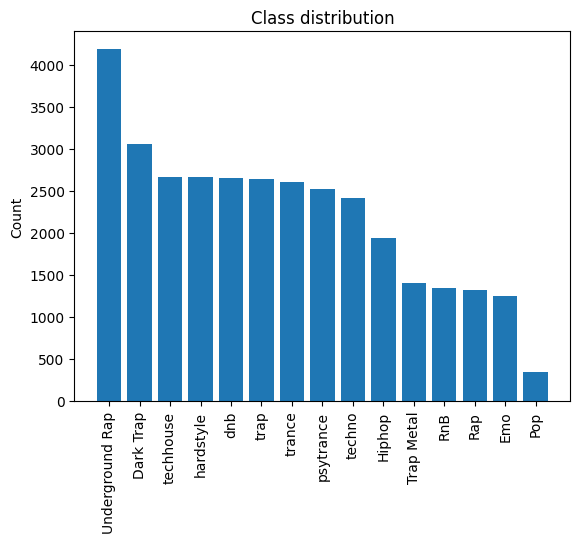

In [15]:
# Visualize label distribution in bar graph.
labels_size = list(label_groups_dt.size())

genre_size = {k: v for k, v in zip(unique_genres, labels_size)}
sorted_f1_genre = {k: v for k, v in sorted(genre_size.items(), key=lambda item: item[1], reverse=True)}

x = list(sorted_f1_genre.keys())
y = list(sorted_f1_genre.values())

plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Class distribution')
plt.show()

### Evaluation Metric Functions

The following functions investigate the F1 score, cohesion, and separation of each genre to be later used in analysis of our decision trees' performance.

#### Plot F1 Score by Genre

In [16]:
# Plot the F1 scores from the classification report of our tuned classifier.
def plot_f1_score(class_report):
    # Make a dictionary of f1-scores for each genre.
    f1_genre = {genre: class_report[genre]['f1-score'] for genre in unique_genres}
    
    # Sort the dictionary by f1-score.
    sorted_f1_genre = {k: v for k, v in sorted(f1_genre.items(), key=lambda item: item[1], reverse=True)}

    x = list(sorted_f1_genre.keys())
    y = list(sorted_f1_genre.values())

    plt.bar(x, y)

    plt.xticks(rotation=90)
    plt.ylabel('F1-score')
    plt.title('F1-score for each genre')

    plt.show()
    
    return f1_genre

#### Cohesion

In [17]:
# Calculate the cohesion of each genre and plot with f1-score.
def cohesion_corr(df, f1_genre):
    # Calculate cohesion for each genre.
    rel_cohesion = dict()
    for genre in unique_genres:
        cohesion = 0
        data = df[df['genre'] == genre].drop('genre', axis=1)
        centroid = np.mean(data, axis=0)
        for i in range(0, len(data)):
            record = data.iloc[i, :]
            cohesion += (math.sqrt(((record[0] - centroid[0]) ** 2) + (record[1] - centroid[1]) ** 2)) ** 2
        rel_cohesion[genre] = cohesion / len(data)

    # Sort the dictionary by cohesion value.
    sorted_cohesion = {k: v for k, v in sorted(rel_cohesion.items(), key=lambda item: item[1], reverse=True)}

    # Plot the bar graph of cohesion for each genre.
    x = list(sorted_cohesion.keys())
    y = list(sorted_cohesion.values())

    plt.bar(x, y)

    plt.xticks(rotation=90)
    plt.ylabel('Cohesion')
    plt.title('Cohesion for each genre')

    plt.show()

    # Plot the bar graph of f1-score for each genre.
    f1_genre_values = list(f1_genre.values())
    cohesion_values = list(rel_cohesion.values())

    plt.scatter(cohesion_values, f1_genre_values)

    plt.title("Scatterplot of Cohesion and F1 score")
    plt.xlabel("Cohesion")
    plt.ylabel("F1 score")

    plt.show()

    print("Correlation Coefficient between Cohesion and F1 score", np.corrcoef(f1_genre_values, cohesion_values)[0][1])

#### Separation

In [18]:
# Calculate the separation of each genre and plot with f1-score.
def separation_corr(df, f1_genre):
    features_df = df.drop('genre', axis=1)
    overall_centroid = np.mean(features_df, axis=0) 
    separation_stats = dict()
    centroid_dict = dict()
    for genre in unique_genres:
        data = df[df['genre'] == genre].drop('genre', axis=1)
        centroid_dict[genre] = np.mean(data, axis=0)
        crnt_centroid = np.mean(data, axis=0)
        dist = math.dist(overall_centroid, crnt_centroid) ** 2
        data_size = len(data)
        bss = dist * data_size
        separation_stats[genre] = bss

    # Sort the dictionary by separation value.
    sorted_separation = {k: v for k, v in sorted(separation_stats.items(), key=lambda item: item[1], reverse=True)}

    # Plot the bar graph of separation for each genre.
    x = list(sorted_separation.keys())
    y = list(sorted_separation.values())

    plt.bar(x, y)

    plt.xticks(rotation=90)
    plt.ylabel('Separation')
    plt.title('Separation for each genre')

    plt.show()

    # Plot the bar graph of f1-score for each genre.
    f1_genre_values = list(f1_genre.values())
    separation_values = list(separation_stats.values())

    plt.scatter(separation_values, f1_genre_values)

    plt.title("Scatterplot of Seperation and F1 score")
    plt.xlabel("Seperation")
    plt.ylabel("F1 score")

    plt.show()

    print("Correlation Coefficient between Sepearation and F1 score", np.corrcoef(f1_genre_values, separation_values)[0][1])

### Training with Non-Anomalous Data

We first tried to train the model on entire non-anomalous dataset, skipping the full dataset for this classifier since decision trees are less susceptible to outliers than our other classifiers.

We used grid search to tune for the best performing hyperparameters for criterion (our impurity measure), max_depth of the tree, min_samples_leaf (the minimum number of samples needed to split an internal node), and max_features (the number of features considered in looking for a best split).

                 precision    recall  f1-score   support

      Dark Trap       0.44      0.33      0.38      3184
            Emo       0.56      0.59      0.58      1278
         Hiphop       0.39      0.41      0.40      2038
            Pop       0.13      0.02      0.04       361
            Rap       0.80      0.21      0.33      1341
            RnB       0.30      0.25      0.27      1407
     Trap Metal       0.35      0.20      0.26      1453
Underground Rap       0.41      0.63      0.50      4315
            dnb       0.95      0.96      0.95      2694
      hardstyle       0.80      0.86      0.83      2722
      psytrance       0.88      0.90      0.89      2563
      techhouse       0.85      0.87      0.86      2682
         techno       0.80      0.80      0.80      2423
         trance       0.77      0.81      0.79      2719
           trap       0.76      0.76      0.76      2698

       accuracy                           0.65     33878
      macro avg       0.61   

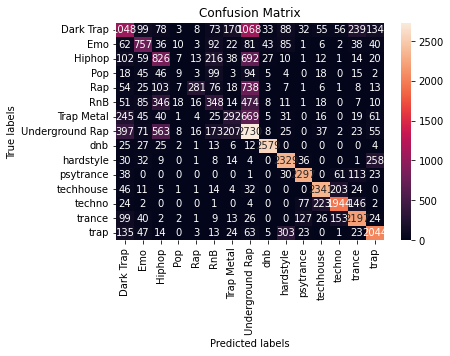

In [158]:
# Running decision tree in dataset without anomalies.
dt_report = decision_tree_clf(features_no_anomalies_dt, labels_no_anomalies_dt)

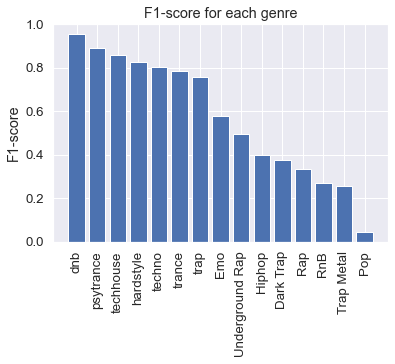

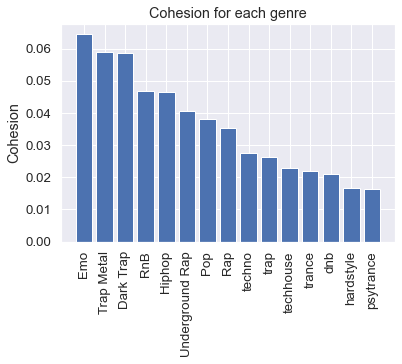

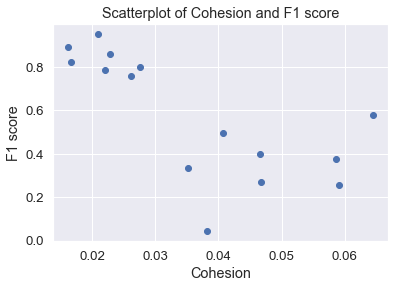

Correlation Coefficient between Cohesion and F1 score -0.709591898678667


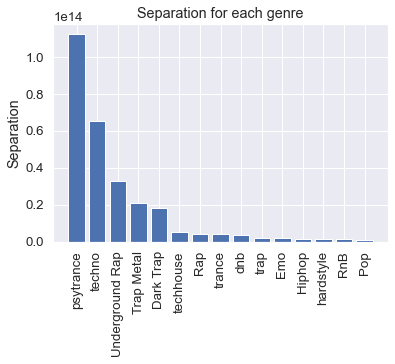

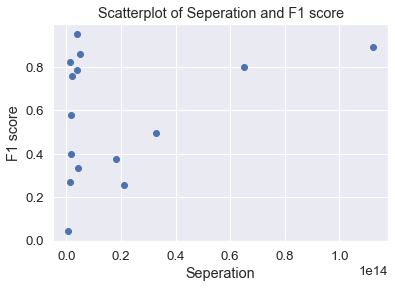

Correlation Coefficient between Sepearation and F1 score 0.3175490474942812


In [253]:
f1_genre = plot_f1_score(dt_report)
cohesion_corr(df_dt, f1_genre)
separation_corr(df_dt, f1_genre)

Once we tuned and trained our decision tree model on this dataset, we noticed that the certain genres achieve higher F1 scores, such as dnb (0.95) and psytrance (0.89), while the others don't, such as Pop (0.04).  We noticed that the genres with more data tended to perform better than underrepresented genres like Pop. 

Both of these observations seem to mirror the results of our imbalanced Naive Bayes classifiers. Therefore, we similarly decided to train the decision tree on our balanced, non-anomalous dataset.

### Training with Downsampled, Balanced Data

At the beginning of this section, we downsampled the non-anomalous, non-one-hot-encoded data to account for the significant class imbalance found in data exploration. After downsampling, we see that in general, F1 scores acorss genres were more balanced. There are still genres that the model performs considerably poorer on, such as Dark Trap (0.32) and RnB (0.31). 

However, this is likely to due to the higher relative cohesion values and their negative correlation with F1 scores found with Naive Bayes. The songs in these genres may be less similar to each other than in genres like dnb and psytrance, making these songs more likely to be split off with other genres in our decision trees.

Although the overall accuracy decreased by 6%, the balanced data most likely provides an model better fit to the true nature of the genres (not a biased version). Fortunately, we did observe that genres that particularly didn’t perform well before downsampling, such as Pop, performed much better with downsampling (Pop's F1 score increased by 47%).

                 precision    recall  f1-score   support

      Dark Trap       0.32      0.31      0.32       361
            Emo       0.59      0.61      0.60       361
         Hiphop       0.36      0.37      0.36       361
            Pop       0.47      0.56      0.51       361
            Rap       0.45      0.47      0.46       361
            RnB       0.32      0.30      0.31       361
     Trap Metal       0.43      0.40      0.42       361
Underground Rap       0.27      0.24      0.25       361
            dnb       0.92      0.92      0.92       361
      hardstyle       0.73      0.78      0.75       361
      psytrance       0.89      0.89      0.89       361
      techhouse       0.79      0.76      0.77       361
         techno       0.77      0.76      0.77       361
         trance       0.75      0.77      0.76       361
           trap       0.73      0.64      0.68       361

       accuracy                           0.59      5415
      macro avg       0.59   

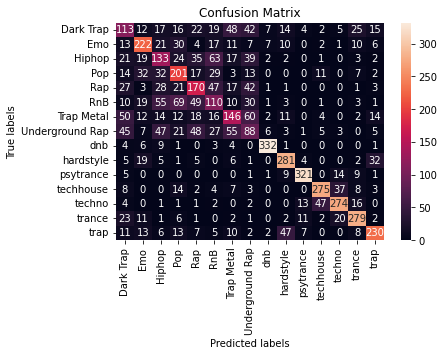

In [169]:
# Train and run decision tree with downsampled data.
samp_dt_report = decision_tree_clf(samp_features_dt, samp_genres_dt)

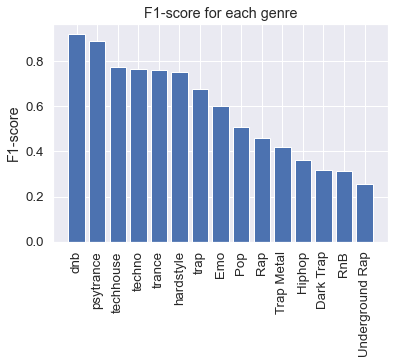

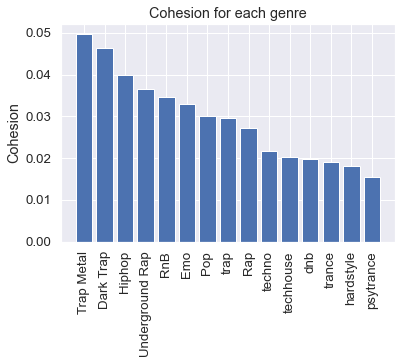

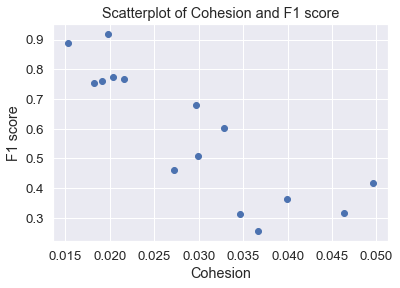

Correlation Coefficient between Cohesion and F1 score -0.8501806946498323


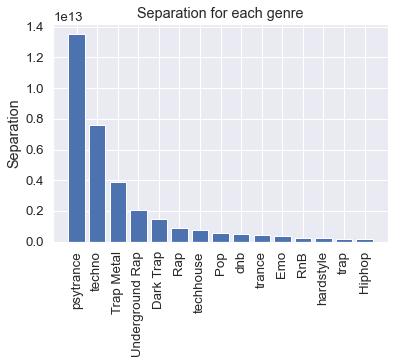

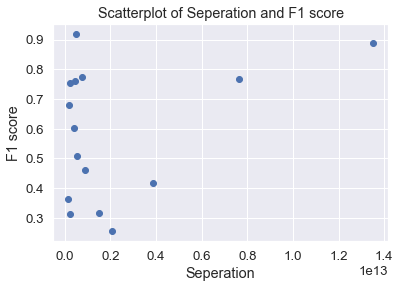

Correlation Coefficient between Sepearation and F1 score 0.34176300021583894


In [254]:
f1_samp_genre = plot_f1_score(samp_dt_report)
downsample_df = pd.concat([samp_features_dt, samp_genres_dt], axis=1)
cohesion_corr(downsample_df, f1_samp_genre)
separation_corr(downsample_df, f1_samp_genre)

### Decision Tree Conclusion

We tested whether there is correlation between WSS (Cohesion) and BSS (Separation) between how well the model performs on each genre (F1 score). For downsampled data (with equal numbers of songs from each genre), we get -0.85 as our correlation coefficient between cohesion and F1 score, and 0.34 as that between separation and F1 score. 

We see stronger negative correlation between the cohesion of the data points in each genre and how well the model performs on that genre. This is on par with what we saw in Naive Bayes. 

For separation, there is weak positive correlation between how separable genre is from other genres and how well the model performs on that genre. Many genres had close to 0 separation, indicating that the genres tend to be very similar to each other and therefore harder to distingush with decision trees.

In the end, although the downsampled classifer had lower accuracy than the entire non-anomalous dataset, its F1 scores across genres were more balanced across the board (improving on the imbalanced data's highly varying levels of performance across gernes).

## Random Forest

Since the decision tree classifier performed 10-15% more accurately than Naive Bayes, we decided to investigate random forest classifiers. We predict the random forest model perform even better than the decision tree because it predicts labels by randomly selecting a subset of input features for different decision trees, rather than using all features for each split. The model ensembles these decision trees and takes their majority vote on the song genre, which may help our problem with the songs' musical features being intermixed across genres. Therefore, with this classifier, we can avoid overfitting and relying on a single best feature for classifying songs.

### Classifer and Analysis Function

In [19]:
# Run random forest classifier on given dataset.
def random_forest_clf(features, labels):
    rf_model = RandomForestClassifier()
    rf_param = {'n_estimators': list(range(50, 150, 50))}

    rf_grid = GridSearchCV(rf_model, rf_param, scoring="accuracy", cv=10)
    y_pred = cross_val_predict(rf_grid, features, labels, cv=10)

    print(classification_report(labels, y_pred))
    report = classification_report(labels, y_pred, output_dict=True)

    confusion_mat = confusion_matrix(labels, y_pred)
    plot_confusion_matrix(confusion_mat)

    # Plot the importance of features in our random forest classifier.
    rf_model = RandomForestClassifier()
    rf_model.fit(features, labels)

    importances = rf_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=list(features.columns))

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

    return report

### Training with Downsampled, Balanced Data

Since the downsampled, balanced data decision trees yielded better F1 scores across genres, we decided to train our random tree classifier on this data from the outset. We tuned for the number of decision tree classifiers in the ensemble. 

We observed that the random forest model performs much better than a single decision tree, as the model's accuracy on the test dataset increased from 0.59 to 0.71 (our best performance yet). In reference to our decision tree classifiers trained on balanced data, F1 scores remained similarly balanced between genres, and less cohesive genres, like Dark Trap, performed worse than more cohesive genres, such as dnb.

                 precision    recall  f1-score   support

      Dark Trap       0.47      0.41      0.44       349
            Emo       0.76      0.80      0.78       349
         Hiphop       0.51      0.51      0.51       349
            Pop       0.70      0.76      0.73       349
            Rap       0.55      0.61      0.58       349
            RnB       0.53      0.47      0.50       349
     Trap Metal       0.55      0.54      0.55       349
Underground Rap       0.40      0.31      0.35       349
            dnb       0.93      0.97      0.95       349
      hardstyle       0.80      0.89      0.84       349
      psytrance       0.92      0.93      0.92       349
      techhouse       0.84      0.87      0.86       349
         techno       0.85      0.87      0.86       349
         trance       0.79      0.83      0.81       349
           trap       0.83      0.80      0.82       349

       accuracy                           0.71      5235
      macro avg       0.70   

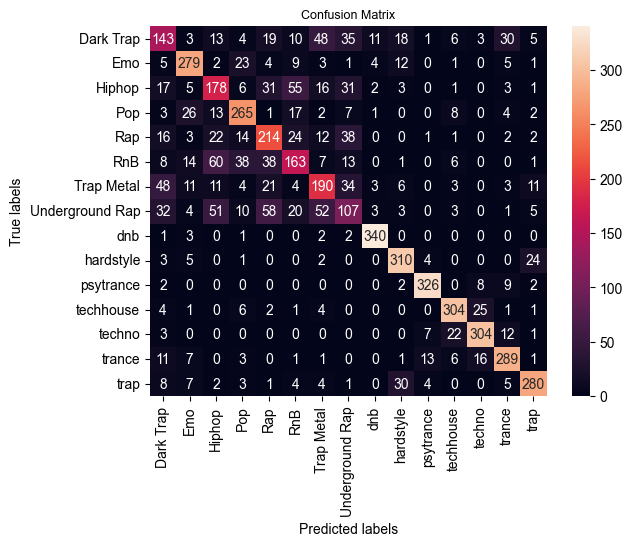

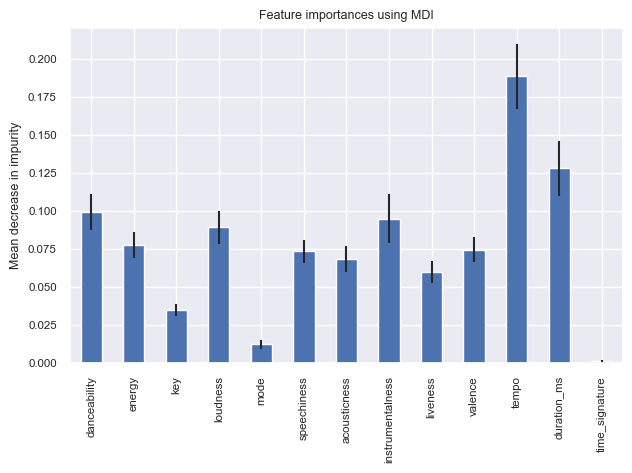

In [20]:
rf_report = random_forest_clf(samp_features_dt, samp_genres_dt)

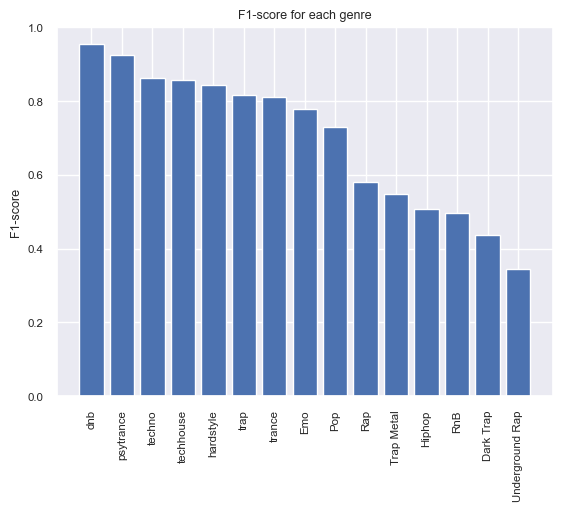

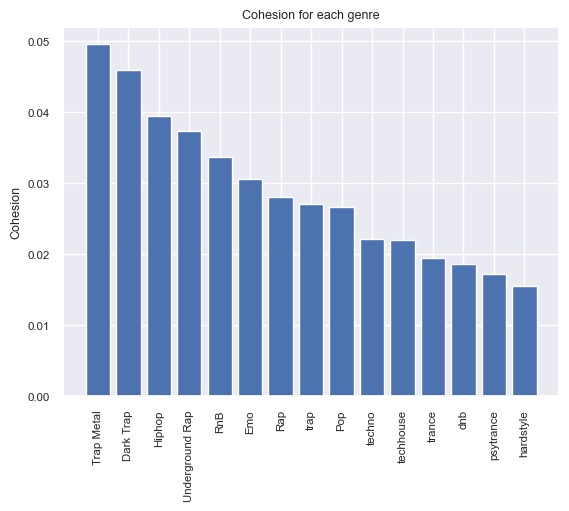

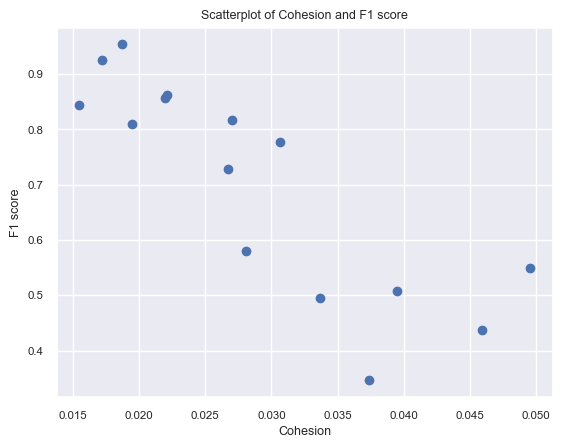

Correlation Coefficient between Cohesion and F1 score -0.8415356210449625


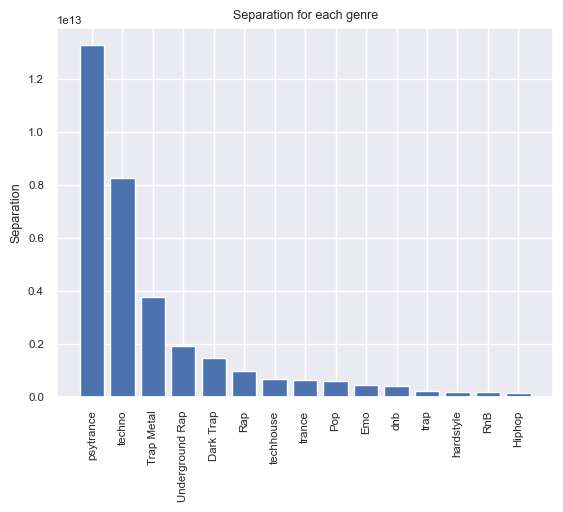

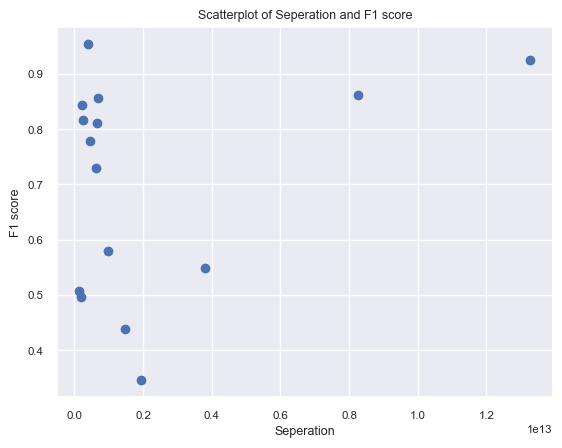

Correlation Coefficient between Sepearation and F1 score 0.28820545971354883


In [21]:
rf_f1_genre = plot_f1_score(rf_report)
downsample_df = pd.concat([samp_features_dt, samp_genres_dt], axis=1)
cohesion_corr(downsample_df, rf_f1_genre)
separation_corr(downsample_df, rf_f1_genre)

### Random Forest Conclusion

To further analyze why random forest performed so much better than Naive Bayes and single decision trees, we plotted what features were most important by using the mean decrease in impurity metrics. We saw that tempo is the most important feature followed by the duration of the song as the second. Features like mode and time signature were the least important features. This makes some intuitive sense, since there exist certain standards in popular music for time signatures, modes, etc. that sound better and have more mass appeal than others.

We again observed a now familiar correlation between the cohesion measure and the model's performance in each genre and separation and model performance.

In the end, random forest is the best performing classifer yet with our non-anomalous, balanced data by an increase of 0.10-0.20 in model accuracy (depending on whether you are comparing it with Naive Bayes or decision trees). Ensembling seems to work well with this data's intermixed song features and genre classifications, as our best splits in normal decision tree classifiers are likely no better than a random choice anyways.

## Neural Network

<p>We decided to use a Neural Network because it benefits from learning from large training datasets and isn't susceptible to the curse of dimensionality (as it will simply adjust weights based on the importance of a particular feature in classification). Additionally, since our data does not seem to be linearly separable and our songs across genres seem to share similar musical features, this complex classifier may be able to find underlying subtle patterns other classifers cannot.</p>

### Training with Full Dataset

</p> For our neural networks, we will use multilayer perceptrons to try to capture subtle relationships between musical features in our datasets. First using the entire dataset with 42,305 records (anomalies included), tuning for the size of each hidden layer, the activation function, the solver or weight optimization, alpha, and the learning rate. In our nested CV process, we scaled our training set data since this is a mathematics-based classifier. </p>

In [177]:
# Declare scaler and classifier.
scaler = StandardScaler()
mlp_orig = MLPClassifier(random_state=1, early_stopping=True, max_iter=50)

# Define hyperparameters and their potential values to tune in nested CV.
mlp_param = {
    'mlp__hidden_layer_sizes': list(range(90, 110, 10)),
    'mlp__activation': ('logistic', 'tanh', 'relu'),
    'mlp__solver': ('sgd','adam'),
    'mlp__alpha': (0.0001, 0.05),
    'mlp__learning_rate': ('constant','adaptive') 
}

# Create pipeline with scaler and mlp classifier.
mlp_orig_pipe = Pipeline([('scaler', scaler), ('mlp', mlp_orig)])

# Do a grid search to get best hyperparameters.
mlp_orig_grid = GridSearchCV(mlp_orig_pipe, mlp_param, n_jobs=-1, cv=5)

# Perform cross val prediction to get accuracy on the full dataset.
y_orig_pred = cross_val_predict(mlp_orig_grid, features, labels, cv=5)

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ashak\AppData\Lo

Results on the entire dataset:
                 precision    recall  f1-score   support

      Dark Trap       0.54      0.40      0.46      4578
            Emo       0.62      0.62      0.62      1680
         Hiphop       0.43      0.39      0.41      3028
            Pop       0.23      0.05      0.08       461
            Rap       0.56      0.31      0.40      1848
            RnB       0.36      0.35      0.35      2099
     Trap Metal       0.48      0.27      0.35      1956
Underground Rap       0.44      0.65      0.52      5875
            dnb       0.92      0.96      0.94      2966
      hardstyle       0.80      0.90      0.84      2936
      psytrance       0.90      0.90      0.90      2961
      techhouse       0.84      0.87      0.85      2975
         techno       0.84      0.85      0.85      2956
         trance       0.77      0.82      0.79      2999
           trap       0.80      0.78      0.79      2987

       accuracy                           0.66     4230

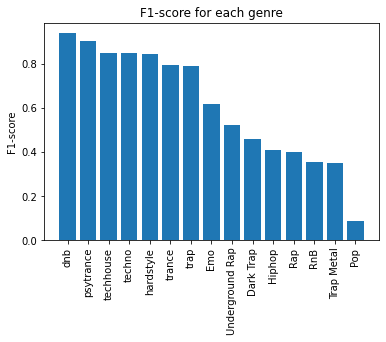

{'Dark Trap': 0.45774647887323944,
 'Emo': 0.6172177539469765,
 'Hiphop': 0.40793595544726763,
 'Pop': 0.08465608465608465,
 'Rap': 0.3988803358992302,
 'RnB': 0.35414634146341467,
 'Trap Metal': 0.35052219321148825,
 'Underground Rap': 0.5222426595817153,
 'dnb': 0.9390586292320395,
 'hardstyle': 0.843604930366576,
 'psytrance': 0.9033237725662223,
 'techhouse': 0.8499257057949479,
 'techno': 0.8459591699004555,
 'trance': 0.7947513364652519,
 'trap': 0.7913912896119303}

In [178]:
# Print classification report and plot f1-score.
print('Results on the entire dataset:')
print (classification_report(labels, y_orig_pred))
orig_report = classification_report(labels, y_orig_pred, output_dict=True)
plot_f1_score(orig_report)

Confusion matrix for the original dataset:


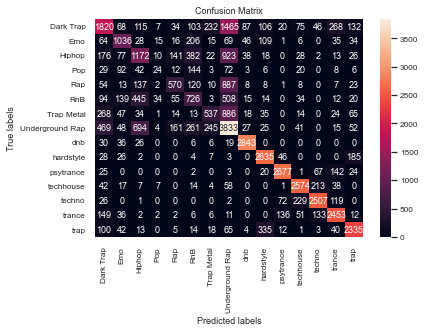

In [269]:
# print confusion matrix after testing model on full dataset
print('Confusion matrix for the original dataset:')
cm_orig = confusion_matrix(labels,y_orig_pred)
plot_confusion_matrix(cm_orig)

The MLPClassifier predicted the correct genre with 66% accuracy overall for the full dataset, faring better than that of Naive Bayes (which was 49%). Since this full dataset contains class imbalance, however, we need to look to F1 scores to get a better insight into the classifier's performance.

Again, the smallest class Pop performed worst with an F1 score of 0.08, and Dark Trap and Underground Rap, despite having the most songs in the dataset, both performed moderately well (middling around 0.46 and 0.52, respectively). Finally, we again see dnb and psytrance perform the best (0.94 and 0.90, respectively). Based on our plot of these F1 scores, the spread of the F1 scores is surprisingly more balanced than Naive Bayes on the same dataset (which had F1 scores of 0 for 3 classes).

### Training with Non-Anomalous Data

<p> To investigate the difference anomalies make on our neural networks, we trained it on the dataset with anomalies removed (according to the anomaly detection process from earlier). We tuned for the same hyperparameters as in the above model.</p>

In [181]:
# Declare scaler and classifier
scaler = StandardScaler()
mlp_noanom = MLPClassifier(random_state=1, early_stopping=True, max_iter=100)

# Hyperparameter options
mlp_param = {
    'mlp__hidden_layer_sizes': list(range(90, 110, 10)),
    'mlp__activation': ('logistic', 'tanh', 'relu'),
    'mlp__solver': ('sgd','adam'),
    'mlp__alpha': (0.0001, 0.05),
    'mlp__learning_rate': ('constant','adaptive') 
}

# Create pipeline with scaler and mlp classifier
mlp_noanom_pipe = Pipeline([('scaler', scaler), ('mlp', mlp_noanom)])

# Do a grid search to get best hyperparameters
mlp_noanom_grid = GridSearchCV(mlp_noanom_pipe, mlp_param, n_jobs=-1, cv=5)

# Perform cross val prediction to get accuracy on the dataset w/o anomalies
y_noanom_pred = cross_val_predict(mlp_noanom_grid, features_no_anomalies, labels_no_anomalies, cv=5)

Results on the dataset without anomalies:
                 precision    recall  f1-score   support

      Dark Trap       0.51      0.35      0.42      3191
            Emo       0.69      0.63      0.66      1245
         Hiphop       0.48      0.38      0.42      2037
            Pop       0.30      0.12      0.18       362
            Rap       0.47      0.24      0.31      1291
            RnB       0.37      0.35      0.36      1410
     Trap Metal       0.45      0.29      0.35      1419
Underground Rap       0.43      0.66      0.52      4310
            dnb       0.93      0.97      0.95      2758
      hardstyle       0.81      0.90      0.85      2664
      psytrance       0.91      0.91      0.91      2703
      techhouse       0.84      0.88      0.86      2789
         techno       0.84      0.83      0.84      2479
         trance       0.78      0.84      0.80      2767
           trap       0.80      0.80      0.80      2727

       accuracy                           0.

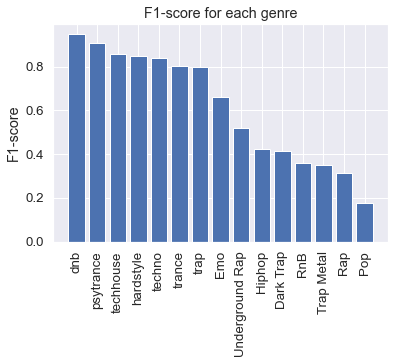

{'Dark Trap': 0.4165277005743932,
 'Emo': 0.6602429828236279,
 'Hiphop': 0.4240766073871409,
 'Pop': 0.17578125,
 'Rap': 0.3141683778234086,
 'RnB': 0.35914454277286134,
 'Trap Metal': 0.35019455252918286,
 'Underground Rap': 0.5213943194393212,
 'dnb': 0.9474058280028429,
 'hardstyle': 0.8504440497335702,
 'psytrance': 0.9073423340114667,
 'techhouse': 0.8584905660377358,
 'techno': 0.8386704499391975,
 'trance': 0.8045937010614234,
 'trap': 0.7980241492864983}

In [183]:
# print classification report and plot f1-scores
print('Results on the dataset without anomalies:')
noanom_report = classification_report(labels_no_anomalies, y_noanom_pred, output_dict=True)
print (classification_report(labels_no_anomalies, y_noanom_pred))
plot_f1_score(noanom_report)

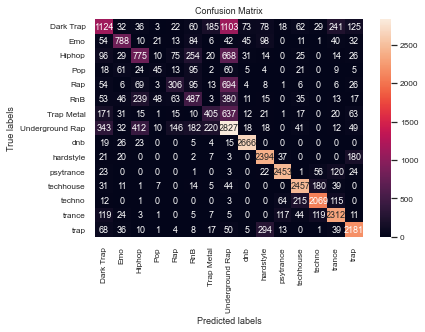

In [270]:
# print confusion matrix after testing model on dataset w/o anomalies
cm_noanom = confusion_matrix(labels_no_anomalies,y_noanom_pred)
plot_confusion_matrix(cm_noanom)

This model's accuracy increased slightly to 68%. This could be because the records that were considered edge cases (most unlike the other records in that class) have been removed so there are fewer records that are more likely to be misclassified by the model. Also notable was the 0.10 increase in Pop's F1 score, indicating that despite the modest increase in accuracy, certain genres benefitted a good amount from this change.

### Training with Downsampled, Balanced Data

<p>To complete our analysis of neural networks' performance on our dataset, we used the downsampled dataset to mitigate for class imbalance (sampled same number of records from each class). We again tuned the same hyperparameters as the other neural networks above.</p>

In [186]:
# Declare scaler and classifier
scaler = StandardScaler()
mlp_down = MLPClassifier(random_state=1, early_stopping=True, max_iter=50)

# Hyperparameter options
mlp_param = {
    'mlp__hidden_layer_sizes': list(range(90, 110, 10)),
    'mlp__activation': ('logistic', 'tanh', 'relu'),
    'mlp__solver': ('sgd','adam'),
    'mlp__alpha': (0.0001, 0.05),
    'mlp__learning_rate': ('constant','adaptive') 
}

# Create pipeline with scaler and mlp classifier
mlp_down_pipe = Pipeline([('scaler', scaler), ('mlp', mlp_down)])

# Do a grid search to get best hyperparameters
mlp_down_grid = GridSearchCV(mlp_down_pipe, mlp_param, n_jobs=-1, cv=5)

# Perform cross val prediction to get accuracy on the downsampled dataset
y_down_pred = cross_val_predict(mlp_down_grid, samp_features, samp_genres, cv=5)

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1091: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1091: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

Results on the downsampled dataset:
                 precision    recall  f1-score   support

      Dark Trap       0.47      0.30      0.37       362
            Emo       0.61      0.65      0.63       362
         Hiphop       0.47      0.41      0.44       362
            Pop       0.52      0.53      0.52       362
            Rap       0.36      0.41      0.39       362
            RnB       0.35      0.34      0.35       362
     Trap Metal       0.48      0.48      0.48       362
Underground Rap       0.32      0.36      0.33       362
            dnb       0.87      0.86      0.87       362
      hardstyle       0.67      0.70      0.69       362
      psytrance       0.82      0.85      0.83       362
      techhouse       0.78      0.80      0.79       362
         techno       0.80      0.82      0.81       362
         trance       0.68      0.71      0.70       362
           trap       0.71      0.69      0.70       362

       accuracy                           0.60    

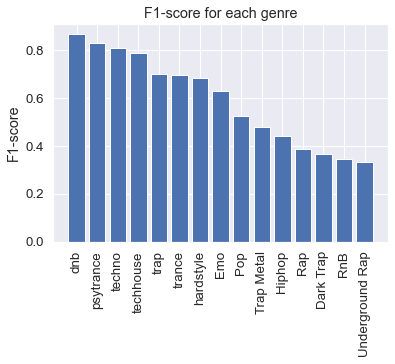

{'Dark Trap': 0.3685092127303183,
 'Emo': 0.6311584553928096,
 'Hiphop': 0.44082840236686394,
 'Pop': 0.5244565217391305,
 'Rap': 0.38809831824062097,
 'RnB': 0.3464788732394366,
 'Trap Metal': 0.48132780082987553,
 'Underground Rap': 0.33463035019455256,
 'dnb': 0.8670360110803323,
 'hardstyle': 0.685483870967742,
 'psytrance': 0.8315217391304347,
 'techhouse': 0.7907608695652174,
 'techno': 0.8087431693989072,
 'trance': 0.6982408660351825,
 'trap': 0.7030812324929971}

In [187]:
# print classification report and plot f1-scores
print('Results on the downsampled dataset:')
down_report = classification_report(samp_genres, y_down_pred, output_dict=True)
print (classification_report(samp_genres, y_down_pred))
plot_f1_score(down_report)

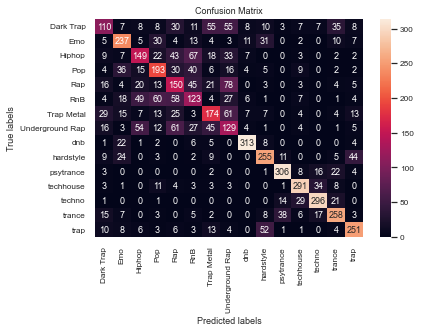

In [271]:
# print confusion matrix after testing model on downsampled dataset
cm_down = confusion_matrix(samp_genres,y_down_pred)
plot_confusion_matrix(cm_down)

This model's accuracy decreased to 60%. Since the records from various classes are so similar (as shown by analysis on the clustering), having a lot more data may have been a strength of the dataset that allowed the model to pick up on more minute differences between records of different classes the more it trained. Now that there are much fewer records from each classes, it is slightly harder for the model to differentiate between classes and it is more likely to misclassify songs.

On the bright side, Pop's F1 score shot up to 0.52, leaving Underground Rap, the previously most represented genre in the dataset, with the worst F1 score of 0.33.

### Neural Networks Conclusion

Across our 3 tested datasets for neural networks, our non-anomalous, imbalanced model performed best in terms of accuracy, most likely due to the neural network's ability to continuously learn with more and more data points. On the other hand, our best balance of F1 scores across genres occurred in our non-anomalous, balanced classifier.

## K-Nearest Neighbors

### Training with Downsampled Data

One of our hypotheses for our dataset is that different songs with similar musical features are more likely to be part of the same genre. Therefore, we decided to perform a K-Nearest-Neighbors classification algorithm in order to classify songs based on the songs with similar characteristics. We first wanted to know the best hyperparameters necessary to use for a KNN Classification, so we performed a fit for a GridSearchCV object first on the non-anomalous, downsampled dataset.

In [189]:
knn_grid = {
    'pca__n_components': list(range(10, 16)),
    'knn__n_neighbors': list(range(5, 20)),
    'knn__weights': ['uniform', 'distance'],
}

knn_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())])

knn_gscv = GridSearchCV(estimator=knn_pipe, param_grid=knn_grid, scoring='accuracy', cv=5)

knn_gscv.fit(samp_features, pd.Series(samp_genres['genre']).ravel())

print("KNN GridSearchCV Best Params: ", knn_gscv.best_params_)
print("KNN GridSearchCV Best Score", knn_gscv.best_score_)

KNN GridSearchCV Best Params:  {'knn__n_neighbors': 16, 'knn__weights': 'distance', 'pca__n_components': 12}
KNN GridSearchCV Best Score 0.5977900552486188


Based on our classification report of our balanced KNN classifier, we see our pattern of relatively balanced F1 score performance, with genres like dnb and psytrance performing very well and Underground Rap performing the worst. This is consistent with the cohesion statistics generated earlier. 

For example, dnb had high precision and recall (0.90 and 0.78, respectively) while being comparatively more cohesive. This implies that songs in this genre are much more similar to each other. Since KNN is based on similarity in music features, KNN performs much better on more cohesive classes such as dnb. Similarly, Dark Trap is relatively less cohesive, meaning that songs in this genre are not as similar to each other and KNN will perform poorly in classifying this genre.

In [192]:
knn_pred = cross_val_predict(knn_gscv, samp_features, pd.Series(samp_genres['genre']).ravel(), cv=5)
knn_report = classification_report(y_true=pd.Series(samp_genres['genre']).ravel(), y_pred=knn_pred)

print("KNN Classifier Report")
print(knn_report)

KNN Classifier Report
                 precision    recall  f1-score   support

      Dark Trap       0.48      0.30      0.37       362
            Emo       0.62      0.72      0.66       362
         Hiphop       0.48      0.44      0.46       362
            Pop       0.51      0.72      0.60       362
            Rap       0.44      0.51      0.47       362
            RnB       0.45      0.41      0.43       362
     Trap Metal       0.53      0.41      0.46       362
Underground Rap       0.37      0.29      0.32       362
            dnb       0.90      0.78      0.84       362
      hardstyle       0.56      0.69      0.62       362
      psytrance       0.72      0.82      0.77       362
      techhouse       0.77      0.73      0.75       362
         techno       0.73      0.84      0.78       362
         trance       0.65      0.57      0.61       362
           trap       0.68      0.69      0.68       362

       accuracy                           0.60      5430
      m

### Training with Full Dataset

Since KNN relies on distances, it is sensitive to noise and outliers; similarly, as KNN also relies on the number of neighbors for a data point, class imbalance can also skew results. So, we ran a classification report for the full dataset to observe the effect of outliers and class imbalance on the accuracy of the KNN model.

In [193]:
param_grid = {
    'pca__n_components': list(range(10, 16)),
    'knn__n_neighbors': list(range(5, 20)),
    'knn__weights': ['uniform', 'distance'],
}


knn_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())])

knn_gscv = GridSearchCV(estimator=knn_pipe, param_grid=param_grid, scoring='accuracy', cv=5)

knn_gscv.fit(features, labels)

print("KNN GridSearchCV Best Params: ", knn_gscv.best_params_)
print("KNN GridSearchCV Best Score", knn_gscv.best_score_)

KNN GridSearchCV Best Params:  {'knn__n_neighbors': 17, 'knn__weights': 'uniform', 'pca__n_components': 15}
KNN GridSearchCV Best Score 0.5757002718354804


Based on the classification results, the accuracy was smaller by minor amount of 0.02. The F1 scores for the full dataset, however, decreased significantly for underrepresetned classes like Pop and Trap Metal, and increased for more populous classes like psytrance. This supports our knowledge of the properties of KNN, as the addition of many more points and outliers for some classes skewed performance in their favor.

In [194]:
knn_accs = cross_val_score(knn_gscv, features, labels, cv=5, scoring='accuracy')

print("Accuracy of KNN Classifier: ", np.average(knn_accs))
print()

knn_pred = cross_val_predict(knn_gscv, features, labels, cv=5)
knn_report = classification_report(y_true=labels, y_pred=knn_pred)

print("KNN Classifier Report")
print(knn_report)

Accuracy of KNN Classifier:  0.572627349013119

KNN Classifier Report
                 precision    recall  f1-score   support

      Dark Trap       0.40      0.30      0.35      4578
            Emo       0.58      0.54      0.56      1680
         Hiphop       0.35      0.30      0.32      3028
            Pop       0.22      0.07      0.11       461
            Rap       0.39      0.25      0.30      1848
            RnB       0.33      0.24      0.28      2099
     Trap Metal       0.22      0.12      0.15      1956
Underground Rap       0.35      0.49      0.41      5875
            dnb       0.88      0.93      0.90      2966
      hardstyle       0.65      0.81      0.72      2936
      psytrance       0.77      0.86      0.81      2961
      techhouse       0.77      0.84      0.80      2975
         techno       0.77      0.83      0.80      2956
         trance       0.69      0.68      0.68      2999
           trap       0.74      0.76      0.75      2987

       accuracy 

## K-Means Clustering

### Exploring the Downsampled, Balanced Data with K-Means

K-Means Clustering relies on clustering data points based on the distances of data points from each other, so it is necessary to create scaled versions for both the downsampled data and the full dataset. We scale and reduce the dimensionality the full datasets here for data exploration purposes.

In [195]:
# Scale the full dataset before performing k-means.
scaled_data = StandardScaler().fit_transform(features.values)
music_data_scaled = pd.DataFrame(scaled_data, columns=features.columns)
music_data_scaled.head()

print("num features before PCA: ", len(features.columns))

pca = PCA(n_components=0.95, svd_solver='full')
pca_data = pca.fit_transform(music_data_scaled)
music_data_pca = pd.DataFrame(pca_data)
music_data_pca.head()

print("num features after PCA: ", len(music_data_pca.columns))

num features before PCA:  16
num features after PCA:  13


In [196]:
# Scale the downsampled dataset before performing k-means.
samp_scaled_data = StandardScaler().fit_transform(samp_features.values)
samp_music_data_scaled = pd.DataFrame(samp_scaled_data, columns=features.columns)
samp_music_data_scaled.head()

print("num features before PCA: ", len(features.columns))

samp_pca = PCA(n_components=0.95, svd_solver='full')
samp_pca_data = samp_pca.fit_transform(samp_music_data_scaled)
samp_music_data_pca = pd.DataFrame(samp_pca_data)
samp_music_data_pca.head()

print("num features after PCA: ", len(music_data_pca.columns))

num features before PCA:  16
num features after PCA:  13


Since each genre class has varying amounts of cohesion, we further investigated the dataset to find whether or not there exists any kind of natural clustering. Based on the plot for the entire dataset in data exploration, the data points from every class are not very separated from each other. Therefore, DBSCAN would perform poorly since it will treat the entire dataset as one cluster. 

Accordingly, we decided to only use KMeans to explore the dataset. In order to determine whether each genre has its own cluster, we ran KMeans with n_clusters=15. The silhouette score of 0.14 is very low due to the poor separation between all of the clusters, so we cannot conclude yet that these clusters have a strong association to the songs' genres.

In [225]:
kmeans = KMeans(n_clusters=15,n_init=10)
kpred = kmeans.fit_predict(samp_music_data_pca)
sil_score = silhouette_score(samp_music_data_pca, kpred, metric='euclidean')

print("Silhouette score for K-Means Clustering with k = 15", sil_score)

Silhouette score for K-Means Clustering with k = 15 0.11613341405007377


To further analyze whether there is an association between the generated clusters and the actual classes, for each cluster, we tried a naïve approach that classified all of the points in one cluster as the most frequently occurring label in that cluster. However, we received poor results from this classification strategy since this classification resulted in multiple clusters being classified under the same label. Furthermore, the impurity of each cluster is very high, so trying to classify the data based on these clusters is not effective.

In [198]:
""" Usage: pandas_entropy(df['column1']) """

# Based on StackOverflow post: https://stackoverflow.com/questions/49685591/how-to-find-the-entropy-of-each-column-of-data-set-by-python
def pandas_gini(column):
    vc = pd.Series(column).value_counts(sort=False)
    return 1 - (np.square((vc / len(column)))).sum()

entropies = []
cluster_labels = []
cluster_names = []

for k in range(0, 15):
    
    # Get all of the data points from the cluster with label k.
    filtered_cluster = samp_genres[kpred == k]

    # Compute the most frequently occurring genre in that cluster.
    lbl = filtered_cluster.value_counts(sort=False).argmax()
    genre_cf = filtered_cluster.mode()
    
    # Add that genre to list to see the majority genre for every cluster.
    cluster_labels.append(lbl)
    cluster_names.append(genre_cf.values[0])
    
    # Append the entropy for the cluster.
    entropies.append(pandas_gini(filtered_cluster['genre']))

print(cluster_names)
print(cluster_labels)
print (entropies)

[array(['psytrance'], dtype=object), array(['techhouse'], dtype=object), array(['trap'], dtype=object), array(['Pop'], dtype=object), array(['Emo'], dtype=object), array(['Pop'], dtype=object), array(['dnb'], dtype=object), array(['RnB'], dtype=object), array(['hardstyle'], dtype=object), array(['Hiphop'], dtype=object), array(['Dark Trap'], dtype=object), array(['hardstyle'], dtype=object), array(['psytrance'], dtype=object), array(['Underground Rap'], dtype=object), array(['techno'], dtype=object)]
[4, 7, 11, 3, 1, 3, 4, 5, 9, 2, 0, 9, 4, 6, 4]
[0.6220174220426713, 0.4559479990602239, 0.7708538790269559, 0.886190300607425, 0.8471303297626549, 0.8718619443712597, 0.8346204301873716, 0.8616204986149585, 0.8218263442505866, 0.7925535781550479, 0.8646454466560287, 0.8871711015311432, 0.8116854107181011, 0.8006844008264462, 0.5297363060208239]


The MDS plot confirms our suspicion of low separation across the genres since each cluster is shown in the same region.

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


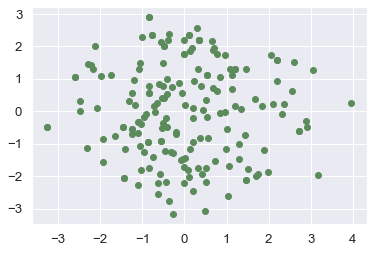

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


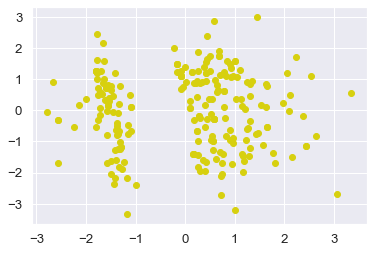

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


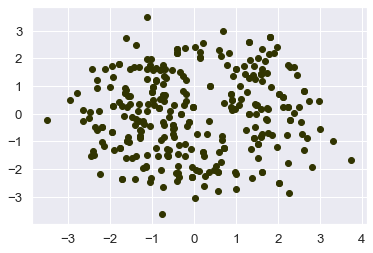

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


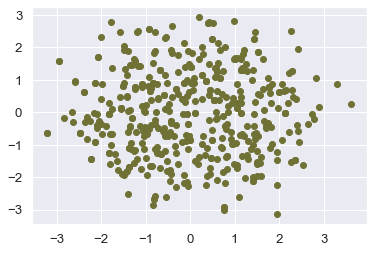

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


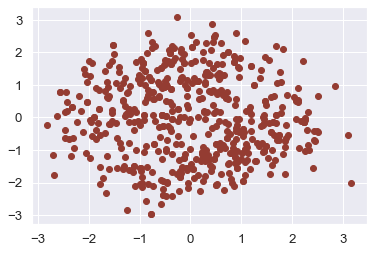

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


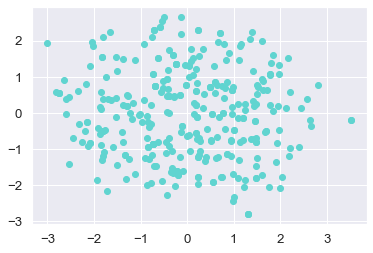

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


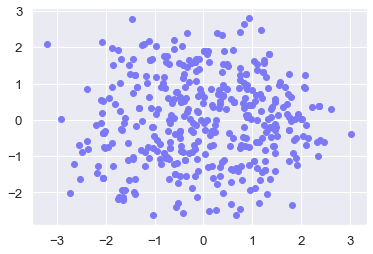

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


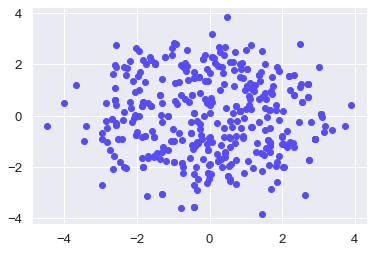

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


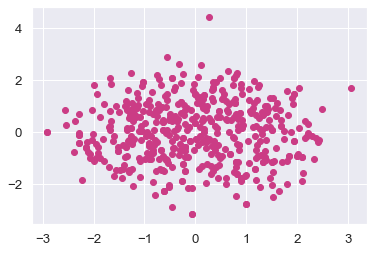

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


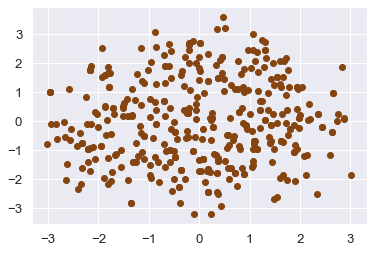

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


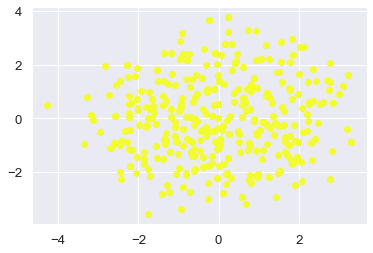

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


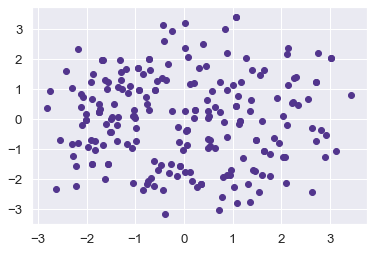

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


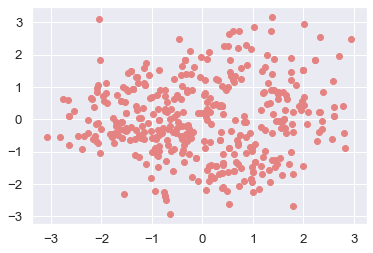

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


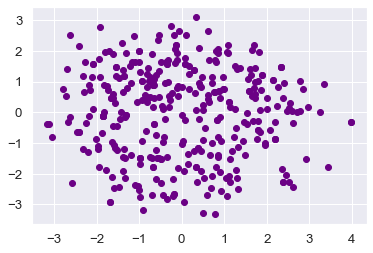

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


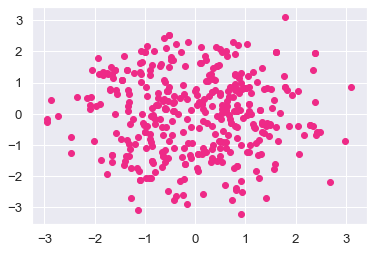

In [199]:
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(15)]

"""
Plot each cluster on its own plot to visually analyze the cohesion and
separation of every cluster.
"""
for k in range(0, 15):

    filtered_label0 = samp_music_data_pca[kpred == k]

    mds = MDS(n_components=3)
    mds_data = mds.fit_transform(filtered_label0)
    plt.scatter(mds_data[:,0] , mds_data[:,1], c=colors[k])
    plt.show()

plt.show()

### Exploring the Full Dataset with K-Means

The KMeans clustering code is now being repeated for the full dataset. Overall, the presence of anomalies has no significant effect on the quality of the clustering for the dataset.

In [226]:
kmeans = KMeans(n_clusters=15,n_init=10)
kpred = kmeans.fit_predict(music_data_pca)
sil_score = silhouette_score(music_data_pca, kpred, metric='euclidean')

print("Silhouette score for K-Means Clustering with k = 15", sil_score)

Silhouette score for K-Means Clustering with k = 15 0.14730707521132744


In [201]:
""" Usage: pandas_entropy(df['column1']) """

# Based on StackOverflow post: https://stackoverflow.com/questions/49685591/how-to-find-the-entropy-of-each-column-of-data-set-by-python
entropies = []
cluster_labels = []
cluster_names = []

for k in range(0, 15):

    # Get all data points in one cluster.
    filtered_cluster = labels[kpred == k]

    # Get most frequently occurring genre in that cluster.
    lbl = filtered_cluster.value_counts(sort=False).argmax()
    genre_cf = filtered_cluster.mode()
    
    cluster_labels.append(lbl)
    cluster_names.append(genre_cf.values[0])

    entropies.append(pandas_gini(filtered_cluster))

print(cluster_names)
print(cluster_labels)
print(entropies)

['techno', 'psytrance', 'dnb', 'Dark Trap', 'Dark Trap', 'Dark Trap', 'Dark Trap', 'Underground Rap', 'techno', 'techhouse', 'Underground Rap', 'Dark Trap', 'Underground Rap', 'trap', 'hardstyle']
[8, 11, 13, 0, 0, 0, 0, 1, 8, 8, 1, 0, 1, 11, 14]
[0.8000162184831692, 0.8726610081803886, 0.8605975525009247, 0.8552614819303616, 0.7987243938173778, 0.9001003391071501, 0.8652444444444445, 0.7704646515466214, 0.747057679285934, 0.8530192001197208, 0.7093553329785003, 0.8326335218505548, 0.8607887794408602, 0.7948773207268592, 0.819672514340457]


C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


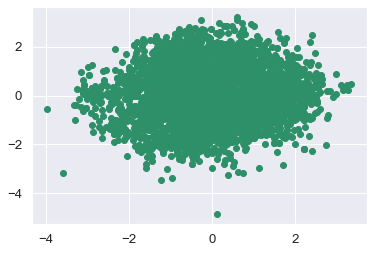

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


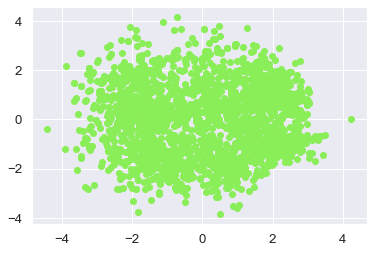

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


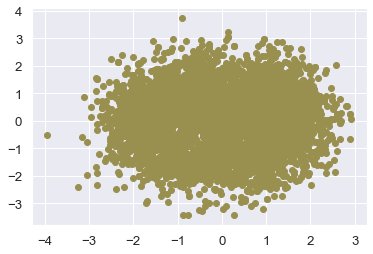

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


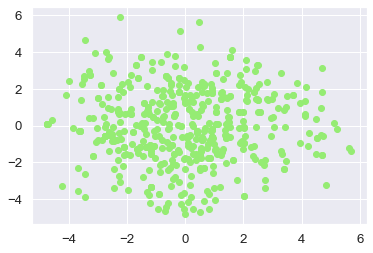

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


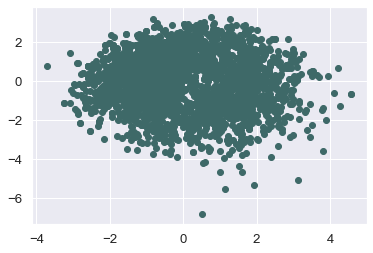

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


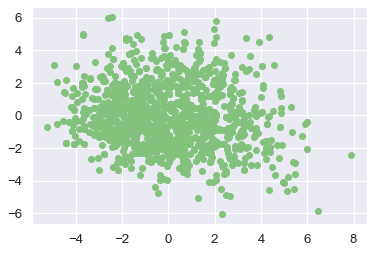

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


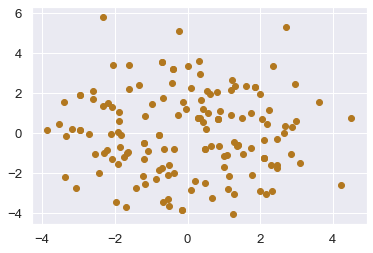

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


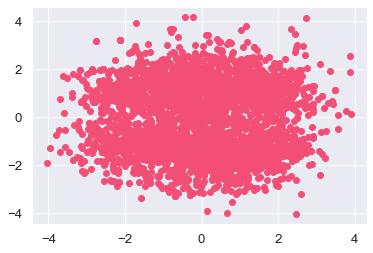

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


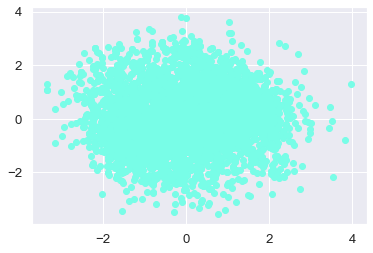

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


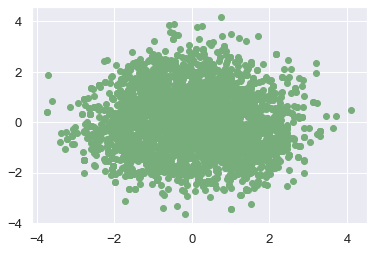

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


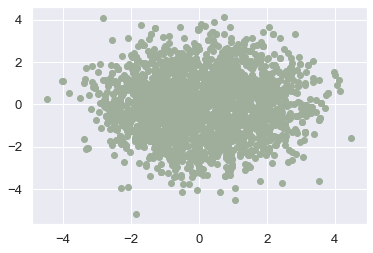

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


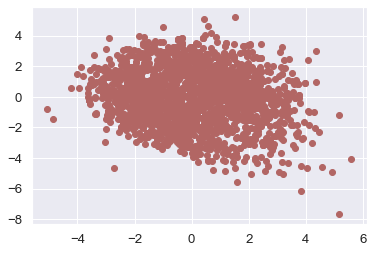

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


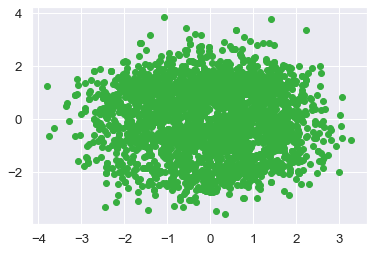

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


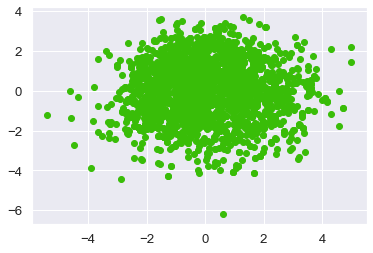

C:\Users\ashak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


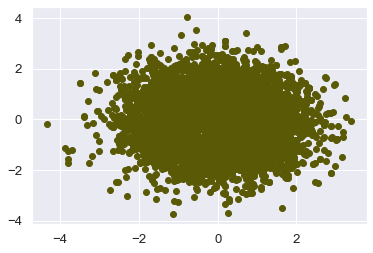

In [202]:
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(15)]

for k in range(0, 15):

    # Show each cluster on its own plot.
    filtered_label0 = music_data_pca[kpred == k]

    mds = MDS(n_components=3)
    mds_data = mds.fit_transform(filtered_label0)
    plt.scatter(mds_data[:,0] , mds_data[:,1], c=colors[k])
    plt.show()

plt.show()

## Hierarchical Clustering

 ### Exploring the Downsampled, Balanced Data with Hierarchical Clustering
 
Another hypothesis that we had was that the dataset has an existing hierarchy since some of our genres are subgenres of one another. In order to determine this, we used a hierarchical clustering algorithm to determine the best proximity metric to use for the dataset based on the CPCC.

In [203]:
def find_best_hier_params(centers):
    proximity_matrix = pdist(centers)
    methods = ['single', 'complete', 'average', 'centroid', 'ward']
    cpccs = []

    # Compute correlation for every linkage method and get the method with highest corr.
    for method in methods:
        link_matrix = linkage(centers, method)
        cpcc, _ = cophenet(link_matrix, proximity_matrix)
        cpccs.append(cpcc)

    print ("The ", methods[np.argmax(cpccs)], "method worked best since it had the highest CPCC of", np.amax(cpccs))
    
    return methods[np.argmax(cpccs)]

Since our dataset is extremely large, visualizing a hierarchy among the data is practically uninterpretable. Therefore, we used the centroids generated from our previous exploratory K-means clustering and then performed a hierarchical clustering algorithm on the centroids. However, this limits our ability to determine the existence of a genre data hierarchy since the impurity for each cluster is very high. Therefore, there is no effective way in determining a hierarchy for this dataset.

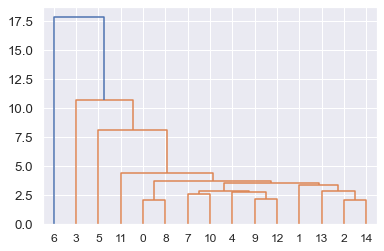

In [204]:
centers = kmeans.cluster_centers_
hier = linkage(centers, 'average')
plt.figure()
dn = dendrogram(hier)
plt.show()

Although a silhouette score tells a lot of information about the clustering algorithm regarding the cohesion and separation, we also wanted to know the silhouette score relative to each cluster to compare and contrast the level of quality for all of the clusters. 

Based on the silhouette plot, each cluster has a steep decline in silhouette score, and every cluster has data points with negative silhouette scores. This can be attributed to the observations noted earlier that the clusters are mixed together in the same general region.

In [227]:
# Based on https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
def silhouette_plot(music_data_pca, n_clusters=15):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot.
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1].
    ax1.set_xlim([-0.1, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(music_data_pca) + (n_clusters + 1) * 10])

    cur_kpred = KMeans(n_clusters=n_clusters,n_init=10).fit_predict(music_data_pca)

    avg_sil_score = silhouette_score(music_data_pca, cur_kpred, metric='euclidean')
    sample_silhouette_values = silhouette_samples(music_data_pca, cur_kpred)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them.
        ith_cluster_silhouette_values = sample_silhouette_values[cur_kpred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = mcm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle.
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot.
        y_lower = y_upper + 10  # 10 for the 0 samples.

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values.
        ax1.axvline(x=avg_sil_score, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks.
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

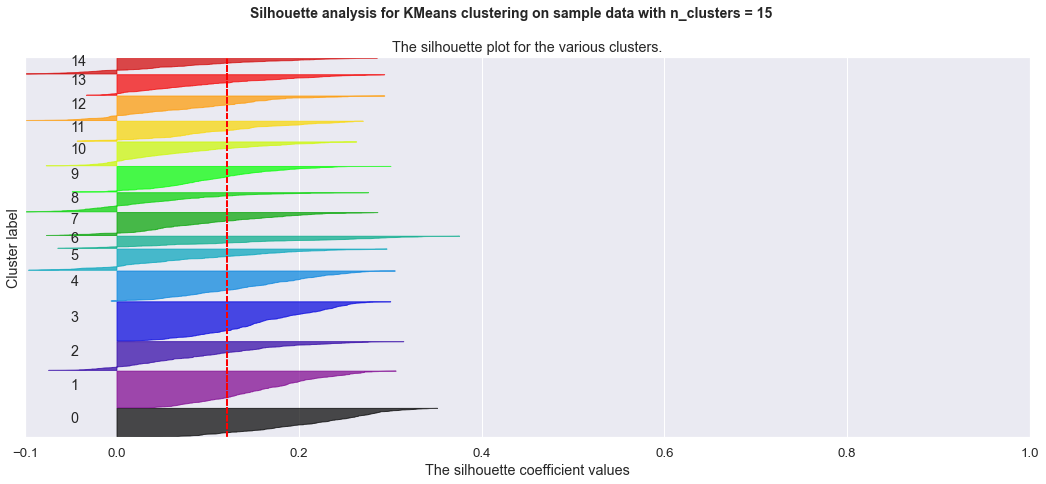

In [228]:
silhouette_plot(samp_music_data_pca, n_clusters=15)

We want to ensure that there is no better k to use when performing the clustering. So, we ran KMeans with k values ranging from 2 to 15. The highest silhouette score was no different than the score for k = 15. So, we can conclude that there does not exist a strong presence of natural clustering in this dataset.

In [229]:
kmeans_sil_scores = []
for i in range(2, 16):
    ith_kmeans = KMeans(n_clusters=i,n_init=10)
    ith_kpred = ith_kmeans.fit_predict(samp_music_data_pca)
    ith_sil_score = silhouette_score(samp_music_data_pca, ith_kpred, metric='euclidean')
    kmeans_sil_scores.append(ith_sil_score)

print ("Best K for K-Means Clustering: ", np.argmax(kmeans_sil_scores) + 2)
print ("Highest silhouette score", np.amax(kmeans_sil_scores))

Best K for K-Means Clustering:  3
Highest silhouette score 0.15423114012634256


### Exploring the Full Dataset with Hierarchical Clustering

The results of the dendrogram show similar results compared to the dendrogram for the sampled data. Therefore, the anomalies still do not impact the hierarchy of the data or the average silhouette scores for each cluster.

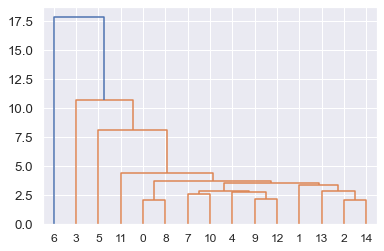

In [216]:
centers = kmeans.cluster_centers_
hier = linkage(centers, 'average')
plt.figure()
dn = dendrogram(hier)
plt.show()

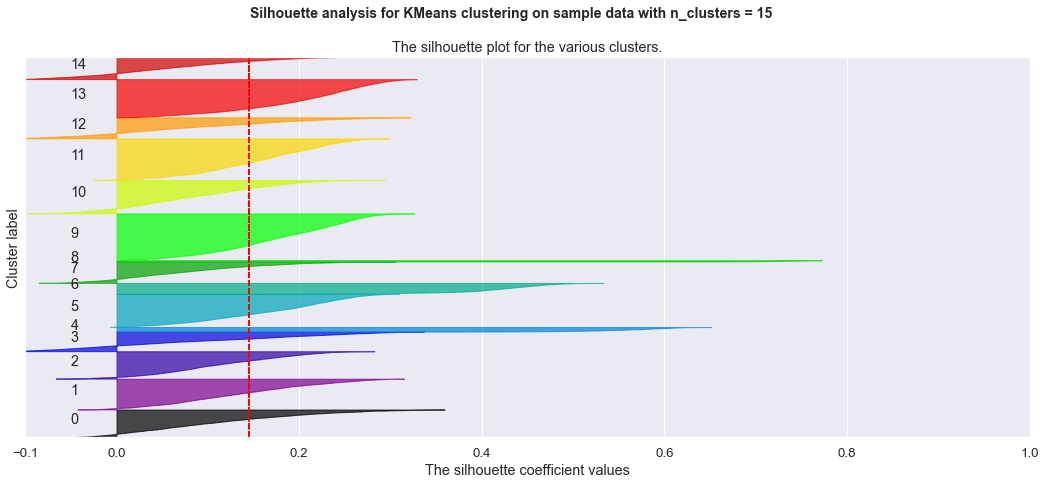

In [230]:
silhouette_plot(music_data_pca, n_clusters=15)

In [232]:
kmeans_sil_scores = []
for i in range(2, 16):
    ith_kmeans = KMeans(n_clusters=i,n_init=10)
    ith_kpred = ith_kmeans.fit_predict(music_data_pca)
    ith_sil_score = silhouette_score(music_data_pca, ith_kpred, metric='euclidean')
    kmeans_sil_scores.append(ith_sil_score)

print ("Best K for K-Means Clustering: ", np.argmax(kmeans_sil_scores) + 2)
print ("Highest silhouette score", np.amax(kmeans_sil_scores))

Best K for K-Means Clustering:  6
Highest silhouette score 0.16760184545189638


## Custom Supervised Clustering Algorithm using K-Means and KNN

Rather than using majority class labeling, we devised another method to perform classification using KMeans clustering, which was inspired by this list of K-Means prototype methods http://www.personal.psu.edu/jol2/course/stat597e/notes2/kmeans.pdf. 

The goal is to generate clusters for each class separately with K cluster centroids per class using the training set and to classify the test set based on which clusters it is closest to. This is a better approach to using K-means clustering since it addresses the issue of class imbalance. In order to implement this algorithm, the function below takes care of generating the clusters for each class and returns the centroids and classes associated with each centroid.

In [233]:
def kmeans_per_label(music_data_pca, labels, clusters_per_label=5):

    pca_df = pd.concat([pd.DataFrame(music_data_pca), pd.DataFrame(labels).reset_index(drop=True)], axis=1)

    group_labels = pca_df.groupby('genre')
    all_genres = pca_df['genre'].unique()

    all_centroids = []
    centroid_labels = []

    for genre in all_genres:
        # Get all data points in one genre.
        cur_group = group_labels.get_group(genre)

        group_data = cur_group.drop('genre', axis=1)
        
        # Perform KMeans on current class group to generate centroids.
        cur_kmeans = KMeans(n_clusters=clusters_per_label,n_init=10)
        cur_kmeans.fit_predict(group_data)
        
        # Add all generated cluster centers to lists.
        for centroid in cur_kmeans.cluster_centers_:
            all_centroids.append(centroid)
            centroid_labels.append(genre)

    return (all_centroids, centroid_labels)

Since we created centroids for every class, we were still curious about whether there exists a hierarchy among the centroids. However, based on the dendrogram, there is no discernable way to determine whether there exists a hierarchy since sub-clusters get merged at similar distances.

The  average method worked best since it had the highest CPCC of 0.7279010115477351


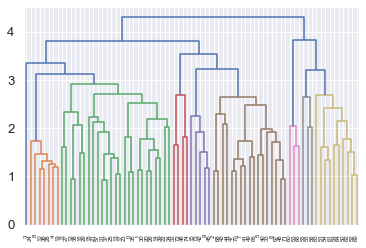

In [234]:
all_centroids, _ = kmeans_per_label(samp_music_data_pca, samp_genres, 5)
hier2 = linkage(all_centroids, find_best_hier_params(all_centroids))
plt.figure()
dn2 = dendrogram(hier2)
plt.show()

Additionally, we created this method to see whether this new algorithm is resistant to cluster overlap and class imbalance. We aimed to perform a cross validation in order to see the desired results. Therefore, we created our own class called “KCentroidsClassifier” that utilizes polymorphism to pass our classifier into existing scikit-learn class objects and function, specifically GridSearchCV and sklearn.model_selection.cross_val. 

The tunable hyperparameters are very similar to those of a KNN Classifier. However, we added an additional clusters_per_label to specify the number of centroids to generate for each class in the dataset. Furthermore, we allow for an n_neighbors parameter in the case that data points are similarly distant from clusters from several centroids.

In [235]:
class KCentroidsClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, clusters_per_label=5, n_neighbors=5, *,
                 weights='uniform', algorithm='auto', leaf_size=30,
                 p=2, metric='minkowski', metric_params=None, n_jobs=None,
                 **kwargs):
        
        # Use the same instance variables as the KNearestNeighbors classifier.
        self.centroids_ = None
        self.classes_ = None
        
        # Additional variable to specify the number of centroids per class.
        self.clusters_per_label = clusters_per_label
        self.weights = weights
        self.leaf_size = leaf_size
        self.p = p
        self.metric = metric
        self.metric_params = metric_params
        self.n_jobs = n_jobs
        self.algorithm = algorithm
        self.n_neighbors = n_neighbors
        self.knn_ = KNeighborsClassifier(n_neighbors=n_neighbors,
                 weights=weights, algorithm=algorithm, leaf_size=leaf_size,
                 p=2, metric=metric, metric_params=metric_params, n_jobs=n_jobs,
                 **kwargs)
        
    def fit(self, X, y):
        self.centroids_, self.classes_ = kmeans_per_label(X, y, self.clusters_per_label)
        self.knn_.fit(self.centroids_, self.classes_)
        return self
    
    def predict(self, X):
        kpred = self.knn_.predict(X)
        return kpred
    
    def predict_proba(self, X):
        return self.knn_.predict_proba(X)

### Checking the New Classifier for Functionality

For the sake of checking that the algorithm produces meaningful predictions for a dataset, we simply passed our entire downsampled scaled dataset into a KCentroidsClassifier object and checked its accuracy. Because this was for exploratory purposes, we will not consider this accuracy in our analysis since it experienced data leakage.

In [236]:
kcc = KCentroidsClassifier(clusters_per_label=5, n_neighbors=1)
kcc.fit(samp_music_data_pca, samp_genres)

kcc_pred = kcc.predict(samp_music_data_pca)
print (accuracy_score(samp_genres, kcc_pred))

0.5099447513812154


To test that our classifier works in a pipeline, we performed a cross validation and reported the overall accuracy of the cross validation.

In [237]:
kcc_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95, svd_solver='full')), ('kcc', KCentroidsClassifier(clusters_per_label=5, n_neighbors=10, weights='distance'))])

pipe_pred = cross_val_score(kcc_pipe, samp_features, samp_genres, cv=5, scoring='accuracy')

print(np.average(pipe_pred))

0.4734806629834255


### Training with Downsampled, Balanced Data

We now want to see the best hyperparameters for KCentroidsClassifier on our original downsampled data, so we passed a Pipeline object with the KCentroidsClassifier into a GridSearchCV object and printed the parameters that produced the best overall accuracy.

In [238]:
kcc_param_grid = {
    'pca__n_components': list(range(11, 16)),
    'kcc__n_neighbors': list(range(1, 5)),
    'kcc__weights': ['uniform', 'distance'],
    'kcc__clusters_per_label': list(range(1, 6))
}

kcc_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('kcc', KCentroidsClassifier())])

kcc_gscv = GridSearchCV(estimator=kcc_pipe, param_grid=kcc_param_grid, scoring='accuracy', cv=5)

kcc_gscv.fit(samp_features, samp_genres)

print("KCentroidsClassifier GridSearchCV Best Params: ", kcc_gscv.best_params_)
print("KCentroidsClassifier GridSearchCV Best Score", kcc_gscv.best_score_)

KCentroidsClassifier GridSearchCV Best Params:  {'kcc__clusters_per_label': 5, 'kcc__n_neighbors': 4, 'kcc__weights': 'distance', 'pca__n_components': 13}
KCentroidsClassifier GridSearchCV Best Score 0.405340699815838


Finally, to determine how well the overall performance for KCentroidsClassifier was, we generated a classification report. Overall, this model's accuracy among the downsampled, non-anomalous classifiers trained previously was relatively low (only 0.03 more than Naive Bayes' 0.45 accuracy). Despite the great amount of overlap among data from different classes, however, KCentroidsClassifier performed well in balancing the F1 scores across classees.

In [239]:
kcc_pred = cross_val_predict(kcc_gscv, samp_features, samp_genres, cv=5)
kcc_report = classification_report(y_true=samp_genres, y_pred=kcc_pred)

print("KCC Classifier Report")
print(kcc_report)

KCC Classifier Report
                 precision    recall  f1-score   support

      Dark Trap       0.36      0.26      0.30       362
            Emo       0.50      0.60      0.54       362
         Hiphop       0.41      0.36      0.38       362
            Pop       0.41      0.44      0.42       362
            Rap       0.35      0.36      0.35       362
            RnB       0.29      0.27      0.28       362
     Trap Metal       0.30      0.25      0.28       362
Underground Rap       0.24      0.22      0.23       362
            dnb       0.78      0.70      0.74       362
      hardstyle       0.43      0.58      0.49       362
      psytrance       0.69      0.75      0.72       362
      techhouse       0.71      0.64      0.67       362
         techno       0.65      0.77      0.70       362
         trance       0.54      0.49      0.51       362
           trap       0.54      0.56      0.55       362

       accuracy                           0.48      5430
      m

### Investigating the Full Dataset

Overall, running KCentroidsClassifier on the full dataset led to even worse overall accuracy (a decrease of 0.04) and a more disparate range of F1 scores between underrepresented and overrepresented classes (similar to previous classifiers' experiences). However, it is difficult to say whether this is a result of anomalies. There is still no noticeable hierarchy among the new centroids.

The  average method worked best since it had the highest CPCC of 0.9943283559165106


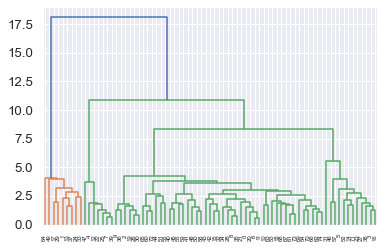

In [240]:
all_centroids, _ = kmeans_per_label(music_data_pca, labels, 5)
hier2 = linkage(all_centroids, find_best_hier_params(all_centroids))
plt.figure()
dn2 = dendrogram(hier2)
plt.show()

In [241]:
# Testing the functionality of the custom classifier for exploratory purposes.
# Model subject to data leakage, so disregarding output in analysis.

kcc = KCentroidsClassifier(clusters_per_label=5, n_neighbors=1)
kcc.fit(music_data_pca, labels)

kcc_pred = kcc.predict(music_data_pca)
print (accuracy_score(labels, kcc_pred))

0.4777685852736083


In [242]:
kcc_param_grid = {
    'pca__n_components': list(range(5, 16)),
    'kcc__n_neighbors': list(range(1, 10)),
    'kcc__weights': ['uniform', 'distance'],
    'kcc__clusters_per_label': list(range(1, 5))
}


kcc_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95, svd_solver='full')), ('kcc', KCentroidsClassifier(clusters_per_label=5, n_neighbors=10, weights='distance'))])

pipe_pred = cross_val_score(kcc_pipe, features, labels, cv=5, scoring='accuracy')

print(np.average(pipe_pred))

0.42855454438009694


In [243]:
kcc_param_grid = {
    'pca__n_components': list(range(11, 16)),
    'kcc__n_neighbors': list(range(1, 5)),
    'kcc__weights': ['uniform', 'distance'],
    'kcc__clusters_per_label': list(range(1, 6))
}

kcc_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('kcc', KCentroidsClassifier())])

kcc_gscv = GridSearchCV(estimator=kcc_pipe, param_grid=kcc_param_grid, scoring='accuracy', cv=5)

kcc_gscv.fit(features, labels)

print("KCentroidsClassifier GridSearchCV Best Params: ", kcc_gscv.best_params_)
print("KCentroidsClassifier GridSearchCV Best Score", kcc_gscv.best_score_)

KCentroidsClassifier GridSearchCV Best Params:  {'kcc__clusters_per_label': 5, 'kcc__n_neighbors': 3, 'kcc__weights': 'distance', 'pca__n_components': 15}
KCentroidsClassifier GridSearchCV Best Score 0.38773194657841864


One important thing to note about KCentroidsClassifier was that it still had decent recall for less frequent classes such as Pop, which shows that KCentroidsClassifier is more robust to class imbalance compared to the previous naïve approach with only K-means clustering.

In [244]:
kcc_pred = cross_val_predict(kcc_gscv, features, labels, cv=5)
kcc_report = classification_report(y_true=labels, y_pred=kcc_pred)

print("KCC Classifier Report")
print(kcc_report)

KCC Classifier Report
                 precision    recall  f1-score   support

      Dark Trap       0.33      0.23      0.27      4578
            Emo       0.27      0.42      0.33      1680
         Hiphop       0.30      0.31      0.30      3028
            Pop       0.06      0.34      0.10       461
            Rap       0.28      0.37      0.32      1848
            RnB       0.20      0.10      0.13      2099
     Trap Metal       0.20      0.20      0.20      1956
Underground Rap       0.46      0.21      0.29      5875
            dnb       0.60      0.82      0.69      2966
      hardstyle       0.47      0.51      0.49      2936
      psytrance       0.61      0.81      0.69      2961
      techhouse       0.65      0.77      0.70      2975
         techno       0.74      0.57      0.64      2956
         trance       0.54      0.46      0.50      2999
           trap       0.52      0.58      0.55      2987

       accuracy                           0.44     42305
      m

### KNN and Clustering Conclusion

After looking further into the clustering tendencies of our classes using K-Means, hierarchical clustering, and our custom classifier incorporating K-Means and KNN, we determined that a cluster-based approach leads to worse performance (on the same level as Naive Bayes, if not worse). This was due to our multiple examples of no natural hierarchial clustering tendencies or clear separation of the songs from each class.

In the end, KNN came out on top as the best classifier in this section, with 57% accuracy for the full dataset and 60% for the balanced, non-anomalous data. This is on par with our neural networks and decision tree classifiers, which all create complex decision boundaries that our intermixed data may benefit from.

# Conclusion

Across our efforts in data exploration, modeling, and analysis across 3 different datasets (all data, non-anomalous and imbalanced, and non-anomalous and balanced), we noticed several key patterns in our results. Whenever we trained our models on the full dataset (anomalies included), we found that performance (as measured by F1 scores) tended to be skewed in favor of our overrepresented genres. For example, Pop, with more than 10x less data in the dataset than the most populous genre, Underground Rap, tended to have the worst F1 scores without mitigating for class imbalance (sometimes having a score of 0). Similarly, Underground Rap's F1 scores usually decreased as it was downsampled. Using balanced, downsampled data tended to better balance performance across genres.

Furthermore, anomalies tended to skew our results a bit, slightly increasing performance of smaller classes. However, this was not as impactful as fully balancing the dataset. 

## Comparing our Classifiers

In terms of accuracy (which we need to keep in mind is not fully representative of variance in class performances), these are the classifiers ranked from worst to best for downsampled, balanced data:

Naive Bayes: 0.45; Custom Classifier: 0.48; Decision Tree: 0.59; K-Nearest Neighbors: 0.60; Neural Network: 0.60; Random Forest: 0.71

Based on these results, it seems that the classifiers that created more complex decision boundaries tended to perform better for this type of data. In our data exploration and analysis within multiple modeling sections, we noted that each of the genres exhibited very low separation from each other, with songs intermixing across different genres into one seemingly giant blob of genres. This indicated that songs across genres shared very similar musical feature values, making our data harder to distinguish and classify from other genres. Cohesion varied across genres, moderately to highly negatively correlating to F1 scores for our classifiers. Therefore, the more complex the decision boundaries and subtler patterns picked up by the classifier, the better, more evenly high performance we saw on our data.

## Future Considerations

In conclusion, our classifiers fared quite well in predicting song genres from musical features, considering we beat the random classification accuracy of 6.67% (among 15 class labels). If we were to revisit this song genre classification problem again in the future, we would seek a more well-balanced set of songs (in terms of genres) from the outset. Furthermore, we'd want data with genres that are more distinct from each other musically, since a major problem of this dataset was that it was heavily biased toward several sets of very similar subgenres. Finally, we'd like to use song names and lyrics as features and employ natural language processing in our models, since these features are more genre-specific than many of the standard musical features across all popular music.